# Training a CNN for Image-Regression to predict the SDAS of a given image

In [1]:
import numpy as np        #library for matrices (useful for data preparation)
import os                 #library for package manage
import cv2                #library for loading images
import tensorflow as tf   #library/framework for all kinds of machine learning tasks
import matplotlib.pyplot as plt #libary for visualisation
import random             #for random seeds

from tensorflow.keras.models import Sequential #"It was trained with the Keras library"
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.initializers import Constant, he_normal

from sklearn.model_selection import train_test_split

from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
import mlflow.keras
from mlflow.tracking import MlflowClient

C:\Users\Kleinau\AppData\Local\anaconda3\envs\cnn_test_env\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


fix random seed. Always use a fixed random seed to guarantee that when you run the code twice you will get the same outcome. This removes a factor of variation and will help keep you sane.

In [2]:
# 1. Python-Seed für allgemeine Zufallszahlen
random.seed(42)

# 2. NumPy-Seed für alle Operationen mit NumPy
np.random.seed(42)

# 3. TensorFlow-Seed für TensorFlow-Operationen
tf.random.set_seed(42)

# 4. Optional: OS-Level Seed für bestimmte Bibliotheken
os.environ['PYTHONHASHSEED'] = '42'

## Model Architecture

In this part we will first define the model architecture of the CNN, we will train later. The implemented structure is directly copied from this study, which also used a CNN to predict SDAS: https://www.mdpi.com/2075-4701/11/5/756 

*In the present case, the CNN model is based on a basic feedforward (sequential) network.*  

In [3]:
#Define the model
model = Sequential() 

*The model consists of three 2D convolutional layer blocks. Each convolutional filter is followed by a Rectified Linear Unit (ReLU) activation, batch normalization and a max-pooling layer. Filter sizes used were (5,5)×32, (3,3)×32 and (2,2)×32 for the first, second and third convolutional layers, respectively. Zero-padding was applied evenly across both dimensions to compensate for edges. The convolutions were performed with stride 1. Each max-pooling filter was of size (2,2), and pooling was performed with stride 2. This resulted in the following intermediate activation maps: 200×200×1 (input), 100×100×32 (following the first convolutional block), 50×50×32 (following the second convolutional block) and 25×25×32 (following the third convolutional block).*

## **Explanation Block 1:**

**Convolutional Layer:** Takes the 200x200x1 image as input in the form of a NumPy array and applies 32 different 5x5 kernels/matrices that slide over the input image. For each 5x5 region, it performs simple multiplication and addition to compute a value. The weights in this layer are the values of the kernel matrices, and they are trained during backpropagation. The resulting output is passed through the ReLU (Rectified Linear Unit) activation function, which sets all negative values to 0 and leaves positive values unchanged. To ensure the width and height of the output do not change compared to the input, zero-padding is used. Without zero-padding, each filter would produce a 196x196 output, but with padding, the output remains at 200x200 per filter, by padding the border rows and columns with zeros.

Trainable parameters: For each filter of size 5x5, we need to train 32×5×5 + 32 (biases) = 832 parameters.

**Batch Normalization Layer:** This layer takes the 32 feature maps of size 200×200 from the previous convolutional layer as input. Batch normalization normalizes the inputs per feature map to have a consistent distribution (approximately a normal distribution with mean 0 and variance 1). Why? This helps the training process by reducing the vanishing gradient effect and making convergence more stable.

Trainable parameters:

For each of the 32 feature maps, there are two trainable parameters: γ (scale) and 𝛽 (shift). That results in 32 × 2 = 64 trainable parameters.
Additionally, the layer stores the mean and variance for the inference phase, which accounts for another 64 non-trainable values.
Therefore, the model summary will show 128 parameters for this layer.

**Max Pooling Layer:** After the convolution, a max pooling layer is applied to retain the most important features while reducing the size. A pooling window (in this case 2×2) slides over the image. Within this window, the maximum value is selected. The window moves with a stride of 2, so the output size is reduced by half.

There are no trainable parameters in this layer.

**Reference links:**

Conv: https://www.youtube.com/watch?v=YRhxdVk_sIs&ab_channel=deeplizard

BN: http://youtube.com/watch?v=dXB-KQYkzNU&ab_channel=deeplizard

MP: https://www.youtube.com/watch?v=ZjM_XQa5s6s&ab_channel=deeplizard

In [4]:
# Block 1
model.add(Conv2D(32, (5,5), strides=1, padding='same', activation='relu', input_shape=(200,200,1))) 
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2,2), strides=2)) 

# Block 2
model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Block 3
model.add(Conv2D(32, (2,2), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

*Activation of the final convolutional block was then flattened to create a meta-layer of 20,000 neurons, which was then followed by a fully-connected layer consisting of 64 neurons, followed by the ReLU activation function and batch normalization.*

## Explanation:

**Flatten Layer:** Transforms the 32 25x25 feature maps from the last max pooling layer by essentially chaining them together. The result is a one-dimensional vector with 20,000 entries. This layer therefore has 20,000 neurons. There are no trainable weights in this layer.

**Dense Layer:** This is a fully connected layer with 64 neurons, where each neuron is connected to all 20,000 input values. The ReLU activation function is used again.

Trainable parameters: Each of the 64 neurons receives 20,000 input weights, so 20,000 × 64 = 1.28 million parameters, plus 64 biases, resulting in a total of 1,280,064 parameters.

**Batch Normalization Layer:** As in Block 1, the input values are normalized here to stabilize and accelerate the training process.

**Dense Layer:** All 64 normalized input values are connected to a single output neuron.

Trainable parameters: 64 × 1 + 1 = 65 parameters

In [5]:
# Flatten & Fully Connected Layer
model.add(Flatten())  # 25x25x32 -> 20000 Neuronen
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

*Finally, this layer was then fully connected to the output layer, which contained a single linear neuron—because of the assumed regression operation. Thus, for a 2D input image of size 200×200×1, a single real value—S value is obtained.*

*init well. Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.*

In [6]:
# Output Layer
model.add(Dense(1, activation='linear', kernel_initializer=he_normal(), bias_initializer=Constant(0.38))) # bias_initializer is user to avoid confusion at the beginning of training (efficient)

*The Adam optimizer was used, using a learning rate of 0.0005.*

In [7]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Modell kompilieren
model.compile(optimizer=optimizer, loss='mse', metrics=['RootMeanSquaredError']) #mse = mean sqaured error learning_rate=0.0005

In [8]:
model.summary() #The total number of parameters was 1,294,977

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      832       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        4

## Import Dataset and Preprocessing

In [9]:
dataset_version = "merged_unaugmented_7.4.25_v1" 

data_dir = f'..\data\paper_data\{dataset_version}' 
files = os.listdir(data_dir)
n_files = len(files)

# Shuffle the file list for random splitting
np.random.shuffle(files)

# Pre-allocate the arrays
input_data = np.empty((n_files, 200, 200, 1), dtype=np.float16)
labels = np.empty(n_files, dtype=np.float16)

# Load and process images in shuffled order
for i, file in enumerate(files):
    print(f"Processing file {i+1}/{n_files}")
    img_path = os.path.join(data_dir, file)
    
    # Load and normalize image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = image / 255.0
    
    # Resize and add dimension
    image = tf.image.resize(image[..., np.newaxis], (200, 200)).numpy()
    input_data[i] = image
    
    # Extract label from filename
    s_value = np.clip(round(float(file[2:5]), 3), 0, 100)
    labels[i] = s_value / 100  # Normalized label

Processing file 1/30685
Processing file 2/30685
Processing file 3/30685
Processing file 4/30685
Processing file 5/30685
Processing file 6/30685
Processing file 7/30685
Processing file 8/30685
Processing file 9/30685
Processing file 10/30685
Processing file 11/30685
Processing file 12/30685
Processing file 13/30685
Processing file 14/30685
Processing file 15/30685
Processing file 16/30685
Processing file 17/30685
Processing file 18/30685
Processing file 19/30685
Processing file 20/30685
Processing file 21/30685
Processing file 22/30685
Processing file 23/30685
Processing file 24/30685
Processing file 25/30685
Processing file 26/30685
Processing file 27/30685
Processing file 28/30685
Processing file 29/30685
Processing file 30/30685
Processing file 31/30685
Processing file 32/30685
Processing file 33/30685
Processing file 34/30685
Processing file 35/30685
Processing file 36/30685
Processing file 37/30685
Processing file 38/30685
Processing file 39/30685
Processing file 40/30685
Processin

Processing file 436/30685
Processing file 437/30685
Processing file 438/30685
Processing file 439/30685
Processing file 440/30685
Processing file 441/30685
Processing file 442/30685
Processing file 443/30685
Processing file 444/30685
Processing file 445/30685
Processing file 446/30685
Processing file 447/30685
Processing file 448/30685
Processing file 449/30685
Processing file 450/30685
Processing file 451/30685
Processing file 452/30685
Processing file 453/30685
Processing file 454/30685
Processing file 455/30685
Processing file 456/30685
Processing file 457/30685
Processing file 458/30685
Processing file 459/30685
Processing file 460/30685
Processing file 461/30685
Processing file 462/30685
Processing file 463/30685
Processing file 464/30685
Processing file 465/30685
Processing file 466/30685
Processing file 467/30685
Processing file 468/30685
Processing file 469/30685
Processing file 470/30685
Processing file 471/30685
Processing file 472/30685
Processing file 473/30685
Processing f

Processing file 776/30685
Processing file 777/30685
Processing file 778/30685
Processing file 779/30685
Processing file 780/30685
Processing file 781/30685
Processing file 782/30685
Processing file 783/30685
Processing file 784/30685
Processing file 785/30685
Processing file 786/30685
Processing file 787/30685
Processing file 788/30685
Processing file 789/30685
Processing file 790/30685
Processing file 791/30685
Processing file 792/30685
Processing file 793/30685
Processing file 794/30685
Processing file 795/30685
Processing file 796/30685
Processing file 797/30685
Processing file 798/30685
Processing file 799/30685
Processing file 800/30685
Processing file 801/30685
Processing file 802/30685
Processing file 803/30685
Processing file 804/30685
Processing file 805/30685
Processing file 806/30685
Processing file 807/30685
Processing file 808/30685
Processing file 809/30685
Processing file 810/30685
Processing file 811/30685
Processing file 812/30685
Processing file 813/30685
Processing f

Processing file 1119/30685
Processing file 1120/30685
Processing file 1121/30685
Processing file 1122/30685
Processing file 1123/30685
Processing file 1124/30685
Processing file 1125/30685
Processing file 1126/30685
Processing file 1127/30685
Processing file 1128/30685
Processing file 1129/30685
Processing file 1130/30685
Processing file 1131/30685
Processing file 1132/30685
Processing file 1133/30685
Processing file 1134/30685
Processing file 1135/30685
Processing file 1136/30685
Processing file 1137/30685
Processing file 1138/30685
Processing file 1139/30685
Processing file 1140/30685
Processing file 1141/30685
Processing file 1142/30685
Processing file 1143/30685
Processing file 1144/30685
Processing file 1145/30685
Processing file 1146/30685
Processing file 1147/30685
Processing file 1148/30685
Processing file 1149/30685
Processing file 1150/30685
Processing file 1151/30685
Processing file 1152/30685
Processing file 1153/30685
Processing file 1154/30685
Processing file 1155/30685
P

Processing file 1446/30685
Processing file 1447/30685
Processing file 1448/30685
Processing file 1449/30685
Processing file 1450/30685
Processing file 1451/30685
Processing file 1452/30685
Processing file 1453/30685
Processing file 1454/30685
Processing file 1455/30685
Processing file 1456/30685
Processing file 1457/30685
Processing file 1458/30685
Processing file 1459/30685
Processing file 1460/30685
Processing file 1461/30685
Processing file 1462/30685
Processing file 1463/30685
Processing file 1464/30685
Processing file 1465/30685
Processing file 1466/30685
Processing file 1467/30685
Processing file 1468/30685
Processing file 1469/30685
Processing file 1470/30685
Processing file 1471/30685
Processing file 1472/30685
Processing file 1473/30685
Processing file 1474/30685
Processing file 1475/30685
Processing file 1476/30685
Processing file 1477/30685
Processing file 1478/30685
Processing file 1479/30685
Processing file 1480/30685
Processing file 1481/30685
Processing file 1482/30685
P

Processing file 1781/30685
Processing file 1782/30685
Processing file 1783/30685
Processing file 1784/30685
Processing file 1785/30685
Processing file 1786/30685
Processing file 1787/30685
Processing file 1788/30685
Processing file 1789/30685
Processing file 1790/30685
Processing file 1791/30685
Processing file 1792/30685
Processing file 1793/30685
Processing file 1794/30685
Processing file 1795/30685
Processing file 1796/30685
Processing file 1797/30685
Processing file 1798/30685
Processing file 1799/30685
Processing file 1800/30685
Processing file 1801/30685
Processing file 1802/30685
Processing file 1803/30685
Processing file 1804/30685
Processing file 1805/30685
Processing file 1806/30685
Processing file 1807/30685
Processing file 1808/30685
Processing file 1809/30685
Processing file 1810/30685
Processing file 1811/30685
Processing file 1812/30685
Processing file 1813/30685
Processing file 1814/30685
Processing file 1815/30685
Processing file 1816/30685
Processing file 1817/30685
P

Processing file 2189/30685
Processing file 2190/30685
Processing file 2191/30685
Processing file 2192/30685
Processing file 2193/30685
Processing file 2194/30685
Processing file 2195/30685
Processing file 2196/30685
Processing file 2197/30685
Processing file 2198/30685
Processing file 2199/30685
Processing file 2200/30685
Processing file 2201/30685
Processing file 2202/30685
Processing file 2203/30685
Processing file 2204/30685
Processing file 2205/30685
Processing file 2206/30685
Processing file 2207/30685
Processing file 2208/30685
Processing file 2209/30685
Processing file 2210/30685
Processing file 2211/30685
Processing file 2212/30685
Processing file 2213/30685
Processing file 2214/30685
Processing file 2215/30685
Processing file 2216/30685
Processing file 2217/30685
Processing file 2218/30685
Processing file 2219/30685
Processing file 2220/30685
Processing file 2221/30685
Processing file 2222/30685
Processing file 2223/30685
Processing file 2224/30685
Processing file 2225/30685
P

Processing file 2514/30685
Processing file 2515/30685
Processing file 2516/30685
Processing file 2517/30685
Processing file 2518/30685
Processing file 2519/30685
Processing file 2520/30685
Processing file 2521/30685
Processing file 2522/30685
Processing file 2523/30685
Processing file 2524/30685
Processing file 2525/30685
Processing file 2526/30685
Processing file 2527/30685
Processing file 2528/30685
Processing file 2529/30685
Processing file 2530/30685
Processing file 2531/30685
Processing file 2532/30685
Processing file 2533/30685
Processing file 2534/30685
Processing file 2535/30685
Processing file 2536/30685
Processing file 2537/30685
Processing file 2538/30685
Processing file 2539/30685
Processing file 2540/30685
Processing file 2541/30685
Processing file 2542/30685
Processing file 2543/30685
Processing file 2544/30685
Processing file 2545/30685
Processing file 2546/30685
Processing file 2547/30685
Processing file 2548/30685
Processing file 2549/30685
Processing file 2550/30685
P

Processing file 2818/30685
Processing file 2819/30685
Processing file 2820/30685
Processing file 2821/30685
Processing file 2822/30685
Processing file 2823/30685
Processing file 2824/30685
Processing file 2825/30685
Processing file 2826/30685
Processing file 2827/30685
Processing file 2828/30685
Processing file 2829/30685
Processing file 2830/30685
Processing file 2831/30685
Processing file 2832/30685
Processing file 2833/30685
Processing file 2834/30685
Processing file 2835/30685
Processing file 2836/30685
Processing file 2837/30685
Processing file 2838/30685
Processing file 2839/30685
Processing file 2840/30685
Processing file 2841/30685
Processing file 2842/30685
Processing file 2843/30685
Processing file 2844/30685
Processing file 2845/30685
Processing file 2846/30685
Processing file 2847/30685
Processing file 2848/30685
Processing file 2849/30685
Processing file 2850/30685
Processing file 2851/30685
Processing file 2852/30685
Processing file 2853/30685
Processing file 2854/30685
P

Processing file 3137/30685
Processing file 3138/30685
Processing file 3139/30685
Processing file 3140/30685
Processing file 3141/30685
Processing file 3142/30685
Processing file 3143/30685
Processing file 3144/30685
Processing file 3145/30685
Processing file 3146/30685
Processing file 3147/30685
Processing file 3148/30685
Processing file 3149/30685
Processing file 3150/30685
Processing file 3151/30685
Processing file 3152/30685
Processing file 3153/30685
Processing file 3154/30685
Processing file 3155/30685
Processing file 3156/30685
Processing file 3157/30685
Processing file 3158/30685
Processing file 3159/30685
Processing file 3160/30685
Processing file 3161/30685
Processing file 3162/30685
Processing file 3163/30685
Processing file 3164/30685
Processing file 3165/30685
Processing file 3166/30685
Processing file 3167/30685
Processing file 3168/30685
Processing file 3169/30685
Processing file 3170/30685
Processing file 3171/30685
Processing file 3172/30685
Processing file 3173/30685
P

Processing file 3455/30685
Processing file 3456/30685
Processing file 3457/30685
Processing file 3458/30685
Processing file 3459/30685
Processing file 3460/30685
Processing file 3461/30685
Processing file 3462/30685
Processing file 3463/30685
Processing file 3464/30685
Processing file 3465/30685
Processing file 3466/30685
Processing file 3467/30685
Processing file 3468/30685
Processing file 3469/30685
Processing file 3470/30685
Processing file 3471/30685
Processing file 3472/30685
Processing file 3473/30685
Processing file 3474/30685
Processing file 3475/30685
Processing file 3476/30685
Processing file 3477/30685
Processing file 3478/30685
Processing file 3479/30685
Processing file 3480/30685
Processing file 3481/30685
Processing file 3482/30685
Processing file 3483/30685
Processing file 3484/30685
Processing file 3485/30685
Processing file 3486/30685
Processing file 3487/30685
Processing file 3488/30685
Processing file 3489/30685
Processing file 3490/30685
Processing file 3491/30685
P

Processing file 3854/30685
Processing file 3855/30685
Processing file 3856/30685
Processing file 3857/30685
Processing file 3858/30685
Processing file 3859/30685
Processing file 3860/30685
Processing file 3861/30685
Processing file 3862/30685
Processing file 3863/30685
Processing file 3864/30685
Processing file 3865/30685
Processing file 3866/30685
Processing file 3867/30685
Processing file 3868/30685
Processing file 3869/30685
Processing file 3870/30685
Processing file 3871/30685
Processing file 3872/30685
Processing file 3873/30685
Processing file 3874/30685
Processing file 3875/30685
Processing file 3876/30685
Processing file 3877/30685
Processing file 3878/30685
Processing file 3879/30685
Processing file 3880/30685
Processing file 3881/30685
Processing file 3882/30685
Processing file 3883/30685
Processing file 3884/30685
Processing file 3885/30685
Processing file 3886/30685
Processing file 3887/30685
Processing file 3888/30685
Processing file 3889/30685
Processing file 3890/30685
P

Processing file 4170/30685
Processing file 4171/30685
Processing file 4172/30685
Processing file 4173/30685
Processing file 4174/30685
Processing file 4175/30685
Processing file 4176/30685
Processing file 4177/30685
Processing file 4178/30685
Processing file 4179/30685
Processing file 4180/30685
Processing file 4181/30685
Processing file 4182/30685
Processing file 4183/30685
Processing file 4184/30685
Processing file 4185/30685
Processing file 4186/30685
Processing file 4187/30685
Processing file 4188/30685
Processing file 4189/30685
Processing file 4190/30685
Processing file 4191/30685
Processing file 4192/30685
Processing file 4193/30685
Processing file 4194/30685
Processing file 4195/30685
Processing file 4196/30685
Processing file 4197/30685
Processing file 4198/30685
Processing file 4199/30685
Processing file 4200/30685
Processing file 4201/30685
Processing file 4202/30685
Processing file 4203/30685
Processing file 4204/30685
Processing file 4205/30685
Processing file 4206/30685
P

Processing file 4486/30685
Processing file 4487/30685
Processing file 4488/30685
Processing file 4489/30685
Processing file 4490/30685
Processing file 4491/30685
Processing file 4492/30685
Processing file 4493/30685
Processing file 4494/30685
Processing file 4495/30685
Processing file 4496/30685
Processing file 4497/30685
Processing file 4498/30685
Processing file 4499/30685
Processing file 4500/30685
Processing file 4501/30685
Processing file 4502/30685
Processing file 4503/30685
Processing file 4504/30685
Processing file 4505/30685
Processing file 4506/30685
Processing file 4507/30685
Processing file 4508/30685
Processing file 4509/30685
Processing file 4510/30685
Processing file 4511/30685
Processing file 4512/30685
Processing file 4513/30685
Processing file 4514/30685
Processing file 4515/30685
Processing file 4516/30685
Processing file 4517/30685
Processing file 4518/30685
Processing file 4519/30685
Processing file 4520/30685
Processing file 4521/30685
Processing file 4522/30685
P

Processing file 4811/30685
Processing file 4812/30685
Processing file 4813/30685
Processing file 4814/30685
Processing file 4815/30685
Processing file 4816/30685
Processing file 4817/30685
Processing file 4818/30685
Processing file 4819/30685
Processing file 4820/30685
Processing file 4821/30685
Processing file 4822/30685
Processing file 4823/30685
Processing file 4824/30685
Processing file 4825/30685
Processing file 4826/30685
Processing file 4827/30685
Processing file 4828/30685
Processing file 4829/30685
Processing file 4830/30685
Processing file 4831/30685
Processing file 4832/30685
Processing file 4833/30685
Processing file 4834/30685
Processing file 4835/30685
Processing file 4836/30685
Processing file 4837/30685
Processing file 4838/30685
Processing file 4839/30685
Processing file 4840/30685
Processing file 4841/30685
Processing file 4842/30685
Processing file 4843/30685
Processing file 4844/30685
Processing file 4845/30685
Processing file 4846/30685
Processing file 4847/30685
P

Processing file 5133/30685
Processing file 5134/30685
Processing file 5135/30685
Processing file 5136/30685
Processing file 5137/30685
Processing file 5138/30685
Processing file 5139/30685
Processing file 5140/30685
Processing file 5141/30685
Processing file 5142/30685
Processing file 5143/30685
Processing file 5144/30685
Processing file 5145/30685
Processing file 5146/30685
Processing file 5147/30685
Processing file 5148/30685
Processing file 5149/30685
Processing file 5150/30685
Processing file 5151/30685
Processing file 5152/30685
Processing file 5153/30685
Processing file 5154/30685
Processing file 5155/30685
Processing file 5156/30685
Processing file 5157/30685
Processing file 5158/30685
Processing file 5159/30685
Processing file 5160/30685
Processing file 5161/30685
Processing file 5162/30685
Processing file 5163/30685
Processing file 5164/30685
Processing file 5165/30685
Processing file 5166/30685
Processing file 5167/30685
Processing file 5168/30685
Processing file 5169/30685
P

Processing file 5554/30685
Processing file 5555/30685
Processing file 5556/30685
Processing file 5557/30685
Processing file 5558/30685
Processing file 5559/30685
Processing file 5560/30685
Processing file 5561/30685
Processing file 5562/30685
Processing file 5563/30685
Processing file 5564/30685
Processing file 5565/30685
Processing file 5566/30685
Processing file 5567/30685
Processing file 5568/30685
Processing file 5569/30685
Processing file 5570/30685
Processing file 5571/30685
Processing file 5572/30685
Processing file 5573/30685
Processing file 5574/30685
Processing file 5575/30685
Processing file 5576/30685
Processing file 5577/30685
Processing file 5578/30685
Processing file 5579/30685
Processing file 5580/30685
Processing file 5581/30685
Processing file 5582/30685
Processing file 5583/30685
Processing file 5584/30685
Processing file 5585/30685
Processing file 5586/30685
Processing file 5587/30685
Processing file 5588/30685
Processing file 5589/30685
Processing file 5590/30685
P

Processing file 5905/30685
Processing file 5906/30685
Processing file 5907/30685
Processing file 5908/30685
Processing file 5909/30685
Processing file 5910/30685
Processing file 5911/30685
Processing file 5912/30685
Processing file 5913/30685
Processing file 5914/30685
Processing file 5915/30685
Processing file 5916/30685
Processing file 5917/30685
Processing file 5918/30685
Processing file 5919/30685
Processing file 5920/30685
Processing file 5921/30685
Processing file 5922/30685
Processing file 5923/30685
Processing file 5924/30685
Processing file 5925/30685
Processing file 5926/30685
Processing file 5927/30685
Processing file 5928/30685
Processing file 5929/30685
Processing file 5930/30685
Processing file 5931/30685
Processing file 5932/30685
Processing file 5933/30685
Processing file 5934/30685
Processing file 5935/30685
Processing file 5936/30685
Processing file 5937/30685
Processing file 5938/30685
Processing file 5939/30685
Processing file 5940/30685
Processing file 5941/30685
P

Processing file 6261/30685
Processing file 6262/30685
Processing file 6263/30685
Processing file 6264/30685
Processing file 6265/30685
Processing file 6266/30685
Processing file 6267/30685
Processing file 6268/30685
Processing file 6269/30685
Processing file 6270/30685
Processing file 6271/30685
Processing file 6272/30685
Processing file 6273/30685
Processing file 6274/30685
Processing file 6275/30685
Processing file 6276/30685
Processing file 6277/30685
Processing file 6278/30685
Processing file 6279/30685
Processing file 6280/30685
Processing file 6281/30685
Processing file 6282/30685
Processing file 6283/30685
Processing file 6284/30685
Processing file 6285/30685
Processing file 6286/30685
Processing file 6287/30685
Processing file 6288/30685
Processing file 6289/30685
Processing file 6290/30685
Processing file 6291/30685
Processing file 6292/30685
Processing file 6293/30685
Processing file 6294/30685
Processing file 6295/30685
Processing file 6296/30685
Processing file 6297/30685
P

Processing file 6618/30685
Processing file 6619/30685
Processing file 6620/30685
Processing file 6621/30685
Processing file 6622/30685
Processing file 6623/30685
Processing file 6624/30685
Processing file 6625/30685
Processing file 6626/30685
Processing file 6627/30685
Processing file 6628/30685
Processing file 6629/30685
Processing file 6630/30685
Processing file 6631/30685
Processing file 6632/30685
Processing file 6633/30685
Processing file 6634/30685
Processing file 6635/30685
Processing file 6636/30685
Processing file 6637/30685
Processing file 6638/30685
Processing file 6639/30685
Processing file 6640/30685
Processing file 6641/30685
Processing file 6642/30685
Processing file 6643/30685
Processing file 6644/30685
Processing file 6645/30685
Processing file 6646/30685
Processing file 6647/30685
Processing file 6648/30685
Processing file 6649/30685
Processing file 6650/30685
Processing file 6651/30685
Processing file 6652/30685
Processing file 6653/30685
Processing file 6654/30685
P

Processing file 6952/30685
Processing file 6953/30685
Processing file 6954/30685
Processing file 6955/30685
Processing file 6956/30685
Processing file 6957/30685
Processing file 6958/30685
Processing file 6959/30685
Processing file 6960/30685
Processing file 6961/30685
Processing file 6962/30685
Processing file 6963/30685
Processing file 6964/30685
Processing file 6965/30685
Processing file 6966/30685
Processing file 6967/30685
Processing file 6968/30685
Processing file 6969/30685
Processing file 6970/30685
Processing file 6971/30685
Processing file 6972/30685
Processing file 6973/30685
Processing file 6974/30685
Processing file 6975/30685
Processing file 6976/30685
Processing file 6977/30685
Processing file 6978/30685
Processing file 6979/30685
Processing file 6980/30685
Processing file 6981/30685
Processing file 6982/30685
Processing file 6983/30685
Processing file 6984/30685
Processing file 6985/30685
Processing file 6986/30685
Processing file 6987/30685
Processing file 6988/30685
P

Processing file 7277/30685
Processing file 7278/30685
Processing file 7279/30685
Processing file 7280/30685
Processing file 7281/30685
Processing file 7282/30685
Processing file 7283/30685
Processing file 7284/30685
Processing file 7285/30685
Processing file 7286/30685
Processing file 7287/30685
Processing file 7288/30685
Processing file 7289/30685
Processing file 7290/30685
Processing file 7291/30685
Processing file 7292/30685
Processing file 7293/30685
Processing file 7294/30685
Processing file 7295/30685
Processing file 7296/30685
Processing file 7297/30685
Processing file 7298/30685
Processing file 7299/30685
Processing file 7300/30685
Processing file 7301/30685
Processing file 7302/30685
Processing file 7303/30685
Processing file 7304/30685
Processing file 7305/30685
Processing file 7306/30685
Processing file 7307/30685
Processing file 7308/30685
Processing file 7309/30685
Processing file 7310/30685
Processing file 7311/30685
Processing file 7312/30685
Processing file 7313/30685
P

Processing file 7609/30685
Processing file 7610/30685
Processing file 7611/30685
Processing file 7612/30685
Processing file 7613/30685
Processing file 7614/30685
Processing file 7615/30685
Processing file 7616/30685
Processing file 7617/30685
Processing file 7618/30685
Processing file 7619/30685
Processing file 7620/30685
Processing file 7621/30685
Processing file 7622/30685
Processing file 7623/30685
Processing file 7624/30685
Processing file 7625/30685
Processing file 7626/30685
Processing file 7627/30685
Processing file 7628/30685
Processing file 7629/30685
Processing file 7630/30685
Processing file 7631/30685
Processing file 7632/30685
Processing file 7633/30685
Processing file 7634/30685
Processing file 7635/30685
Processing file 7636/30685
Processing file 7637/30685
Processing file 7638/30685
Processing file 7639/30685
Processing file 7640/30685
Processing file 7641/30685
Processing file 7642/30685
Processing file 7643/30685
Processing file 7644/30685
Processing file 7645/30685
P

Processing file 7935/30685
Processing file 7936/30685
Processing file 7937/30685
Processing file 7938/30685
Processing file 7939/30685
Processing file 7940/30685
Processing file 7941/30685
Processing file 7942/30685
Processing file 7943/30685
Processing file 7944/30685
Processing file 7945/30685
Processing file 7946/30685
Processing file 7947/30685
Processing file 7948/30685
Processing file 7949/30685
Processing file 7950/30685
Processing file 7951/30685
Processing file 7952/30685
Processing file 7953/30685
Processing file 7954/30685
Processing file 7955/30685
Processing file 7956/30685
Processing file 7957/30685
Processing file 7958/30685
Processing file 7959/30685
Processing file 7960/30685
Processing file 7961/30685
Processing file 7962/30685
Processing file 7963/30685
Processing file 7964/30685
Processing file 7965/30685
Processing file 7966/30685
Processing file 7967/30685
Processing file 7968/30685
Processing file 7969/30685
Processing file 7970/30685
Processing file 7971/30685
P

Processing file 8267/30685
Processing file 8268/30685
Processing file 8269/30685
Processing file 8270/30685
Processing file 8271/30685
Processing file 8272/30685
Processing file 8273/30685
Processing file 8274/30685
Processing file 8275/30685
Processing file 8276/30685
Processing file 8277/30685
Processing file 8278/30685
Processing file 8279/30685
Processing file 8280/30685
Processing file 8281/30685
Processing file 8282/30685
Processing file 8283/30685
Processing file 8284/30685
Processing file 8285/30685
Processing file 8286/30685
Processing file 8287/30685
Processing file 8288/30685
Processing file 8289/30685
Processing file 8290/30685
Processing file 8291/30685
Processing file 8292/30685
Processing file 8293/30685
Processing file 8294/30685
Processing file 8295/30685
Processing file 8296/30685
Processing file 8297/30685
Processing file 8298/30685
Processing file 8299/30685
Processing file 8300/30685
Processing file 8301/30685
Processing file 8302/30685
Processing file 8303/30685
P

Processing file 8670/30685
Processing file 8671/30685
Processing file 8672/30685
Processing file 8673/30685
Processing file 8674/30685
Processing file 8675/30685
Processing file 8676/30685
Processing file 8677/30685
Processing file 8678/30685
Processing file 8679/30685
Processing file 8680/30685
Processing file 8681/30685
Processing file 8682/30685
Processing file 8683/30685
Processing file 8684/30685
Processing file 8685/30685
Processing file 8686/30685
Processing file 8687/30685
Processing file 8688/30685
Processing file 8689/30685
Processing file 8690/30685
Processing file 8691/30685
Processing file 8692/30685
Processing file 8693/30685
Processing file 8694/30685
Processing file 8695/30685
Processing file 8696/30685
Processing file 8697/30685
Processing file 8698/30685
Processing file 8699/30685
Processing file 8700/30685
Processing file 8701/30685
Processing file 8702/30685
Processing file 8703/30685
Processing file 8704/30685
Processing file 8705/30685
Processing file 8706/30685
P

Processing file 8986/30685
Processing file 8987/30685
Processing file 8988/30685
Processing file 8989/30685
Processing file 8990/30685
Processing file 8991/30685
Processing file 8992/30685
Processing file 8993/30685
Processing file 8994/30685
Processing file 8995/30685
Processing file 8996/30685
Processing file 8997/30685
Processing file 8998/30685
Processing file 8999/30685
Processing file 9000/30685
Processing file 9001/30685
Processing file 9002/30685
Processing file 9003/30685
Processing file 9004/30685
Processing file 9005/30685
Processing file 9006/30685
Processing file 9007/30685
Processing file 9008/30685
Processing file 9009/30685
Processing file 9010/30685
Processing file 9011/30685
Processing file 9012/30685
Processing file 9013/30685
Processing file 9014/30685
Processing file 9015/30685
Processing file 9016/30685
Processing file 9017/30685
Processing file 9018/30685
Processing file 9019/30685
Processing file 9020/30685
Processing file 9021/30685
Processing file 9022/30685
P

Processing file 9309/30685
Processing file 9310/30685
Processing file 9311/30685
Processing file 9312/30685
Processing file 9313/30685
Processing file 9314/30685
Processing file 9315/30685
Processing file 9316/30685
Processing file 9317/30685
Processing file 9318/30685
Processing file 9319/30685
Processing file 9320/30685
Processing file 9321/30685
Processing file 9322/30685
Processing file 9323/30685
Processing file 9324/30685
Processing file 9325/30685
Processing file 9326/30685
Processing file 9327/30685
Processing file 9328/30685
Processing file 9329/30685
Processing file 9330/30685
Processing file 9331/30685
Processing file 9332/30685
Processing file 9333/30685
Processing file 9334/30685
Processing file 9335/30685
Processing file 9336/30685
Processing file 9337/30685
Processing file 9338/30685
Processing file 9339/30685
Processing file 9340/30685
Processing file 9341/30685
Processing file 9342/30685
Processing file 9343/30685
Processing file 9344/30685
Processing file 9345/30685
P

Processing file 9633/30685
Processing file 9634/30685
Processing file 9635/30685
Processing file 9636/30685
Processing file 9637/30685
Processing file 9638/30685
Processing file 9639/30685
Processing file 9640/30685
Processing file 9641/30685
Processing file 9642/30685
Processing file 9643/30685
Processing file 9644/30685
Processing file 9645/30685
Processing file 9646/30685
Processing file 9647/30685
Processing file 9648/30685
Processing file 9649/30685
Processing file 9650/30685
Processing file 9651/30685
Processing file 9652/30685
Processing file 9653/30685
Processing file 9654/30685
Processing file 9655/30685
Processing file 9656/30685
Processing file 9657/30685
Processing file 9658/30685
Processing file 9659/30685
Processing file 9660/30685
Processing file 9661/30685
Processing file 9662/30685
Processing file 9663/30685
Processing file 9664/30685
Processing file 9665/30685
Processing file 9666/30685
Processing file 9667/30685
Processing file 9668/30685
Processing file 9669/30685
P

Processing file 9952/30685
Processing file 9953/30685
Processing file 9954/30685
Processing file 9955/30685
Processing file 9956/30685
Processing file 9957/30685
Processing file 9958/30685
Processing file 9959/30685
Processing file 9960/30685
Processing file 9961/30685
Processing file 9962/30685
Processing file 9963/30685
Processing file 9964/30685
Processing file 9965/30685
Processing file 9966/30685
Processing file 9967/30685
Processing file 9968/30685
Processing file 9969/30685
Processing file 9970/30685
Processing file 9971/30685
Processing file 9972/30685
Processing file 9973/30685
Processing file 9974/30685
Processing file 9975/30685
Processing file 9976/30685
Processing file 9977/30685
Processing file 9978/30685
Processing file 9979/30685
Processing file 9980/30685
Processing file 9981/30685
Processing file 9982/30685
Processing file 9983/30685
Processing file 9984/30685
Processing file 9985/30685
Processing file 9986/30685
Processing file 9987/30685
Processing file 9988/30685
P

Processing file 10286/30685
Processing file 10287/30685
Processing file 10288/30685
Processing file 10289/30685
Processing file 10290/30685
Processing file 10291/30685
Processing file 10292/30685
Processing file 10293/30685
Processing file 10294/30685
Processing file 10295/30685
Processing file 10296/30685
Processing file 10297/30685
Processing file 10298/30685
Processing file 10299/30685
Processing file 10300/30685
Processing file 10301/30685
Processing file 10302/30685
Processing file 10303/30685
Processing file 10304/30685
Processing file 10305/30685
Processing file 10306/30685
Processing file 10307/30685
Processing file 10308/30685
Processing file 10309/30685
Processing file 10310/30685
Processing file 10311/30685
Processing file 10312/30685
Processing file 10313/30685
Processing file 10314/30685
Processing file 10315/30685
Processing file 10316/30685
Processing file 10317/30685
Processing file 10318/30685
Processing file 10319/30685
Processing file 10320/30685
Processing file 1032

Processing file 10611/30685
Processing file 10612/30685
Processing file 10613/30685
Processing file 10614/30685
Processing file 10615/30685
Processing file 10616/30685
Processing file 10617/30685
Processing file 10618/30685
Processing file 10619/30685
Processing file 10620/30685
Processing file 10621/30685
Processing file 10622/30685
Processing file 10623/30685
Processing file 10624/30685
Processing file 10625/30685
Processing file 10626/30685
Processing file 10627/30685
Processing file 10628/30685
Processing file 10629/30685
Processing file 10630/30685
Processing file 10631/30685
Processing file 10632/30685
Processing file 10633/30685
Processing file 10634/30685
Processing file 10635/30685
Processing file 10636/30685
Processing file 10637/30685
Processing file 10638/30685
Processing file 10639/30685
Processing file 10640/30685
Processing file 10641/30685
Processing file 10642/30685
Processing file 10643/30685
Processing file 10644/30685
Processing file 10645/30685
Processing file 1064

Processing file 10943/30685
Processing file 10944/30685
Processing file 10945/30685
Processing file 10946/30685
Processing file 10947/30685
Processing file 10948/30685
Processing file 10949/30685
Processing file 10950/30685
Processing file 10951/30685
Processing file 10952/30685
Processing file 10953/30685
Processing file 10954/30685
Processing file 10955/30685
Processing file 10956/30685
Processing file 10957/30685
Processing file 10958/30685
Processing file 10959/30685
Processing file 10960/30685
Processing file 10961/30685
Processing file 10962/30685
Processing file 10963/30685
Processing file 10964/30685
Processing file 10965/30685
Processing file 10966/30685
Processing file 10967/30685
Processing file 10968/30685
Processing file 10969/30685
Processing file 10970/30685
Processing file 10971/30685
Processing file 10972/30685
Processing file 10973/30685
Processing file 10974/30685
Processing file 10975/30685
Processing file 10976/30685
Processing file 10977/30685
Processing file 1097

Processing file 11278/30685
Processing file 11279/30685
Processing file 11280/30685
Processing file 11281/30685
Processing file 11282/30685
Processing file 11283/30685
Processing file 11284/30685
Processing file 11285/30685
Processing file 11286/30685
Processing file 11287/30685
Processing file 11288/30685
Processing file 11289/30685
Processing file 11290/30685
Processing file 11291/30685
Processing file 11292/30685
Processing file 11293/30685
Processing file 11294/30685
Processing file 11295/30685
Processing file 11296/30685
Processing file 11297/30685
Processing file 11298/30685
Processing file 11299/30685
Processing file 11300/30685
Processing file 11301/30685
Processing file 11302/30685
Processing file 11303/30685
Processing file 11304/30685
Processing file 11305/30685
Processing file 11306/30685
Processing file 11307/30685
Processing file 11308/30685
Processing file 11309/30685
Processing file 11310/30685
Processing file 11311/30685
Processing file 11312/30685
Processing file 1131

Processing file 11601/30685
Processing file 11602/30685
Processing file 11603/30685
Processing file 11604/30685
Processing file 11605/30685
Processing file 11606/30685
Processing file 11607/30685
Processing file 11608/30685
Processing file 11609/30685
Processing file 11610/30685
Processing file 11611/30685
Processing file 11612/30685
Processing file 11613/30685
Processing file 11614/30685
Processing file 11615/30685
Processing file 11616/30685
Processing file 11617/30685
Processing file 11618/30685
Processing file 11619/30685
Processing file 11620/30685
Processing file 11621/30685
Processing file 11622/30685
Processing file 11623/30685
Processing file 11624/30685
Processing file 11625/30685
Processing file 11626/30685
Processing file 11627/30685
Processing file 11628/30685
Processing file 11629/30685
Processing file 11630/30685
Processing file 11631/30685
Processing file 11632/30685
Processing file 11633/30685
Processing file 11634/30685
Processing file 11635/30685
Processing file 1163

Processing file 11993/30685
Processing file 11994/30685
Processing file 11995/30685
Processing file 11996/30685
Processing file 11997/30685
Processing file 11998/30685
Processing file 11999/30685
Processing file 12000/30685
Processing file 12001/30685
Processing file 12002/30685
Processing file 12003/30685
Processing file 12004/30685
Processing file 12005/30685
Processing file 12006/30685
Processing file 12007/30685
Processing file 12008/30685
Processing file 12009/30685
Processing file 12010/30685
Processing file 12011/30685
Processing file 12012/30685
Processing file 12013/30685
Processing file 12014/30685
Processing file 12015/30685
Processing file 12016/30685
Processing file 12017/30685
Processing file 12018/30685
Processing file 12019/30685
Processing file 12020/30685
Processing file 12021/30685
Processing file 12022/30685
Processing file 12023/30685
Processing file 12024/30685
Processing file 12025/30685
Processing file 12026/30685
Processing file 12027/30685
Processing file 1202

Processing file 12319/30685
Processing file 12320/30685
Processing file 12321/30685
Processing file 12322/30685
Processing file 12323/30685
Processing file 12324/30685
Processing file 12325/30685
Processing file 12326/30685
Processing file 12327/30685
Processing file 12328/30685
Processing file 12329/30685
Processing file 12330/30685
Processing file 12331/30685
Processing file 12332/30685
Processing file 12333/30685
Processing file 12334/30685
Processing file 12335/30685
Processing file 12336/30685
Processing file 12337/30685
Processing file 12338/30685
Processing file 12339/30685
Processing file 12340/30685
Processing file 12341/30685
Processing file 12342/30685
Processing file 12343/30685
Processing file 12344/30685
Processing file 12345/30685
Processing file 12346/30685
Processing file 12347/30685
Processing file 12348/30685
Processing file 12349/30685
Processing file 12350/30685
Processing file 12351/30685
Processing file 12352/30685
Processing file 12353/30685
Processing file 1235

Processing file 12656/30685
Processing file 12657/30685
Processing file 12658/30685
Processing file 12659/30685
Processing file 12660/30685
Processing file 12661/30685
Processing file 12662/30685
Processing file 12663/30685
Processing file 12664/30685
Processing file 12665/30685
Processing file 12666/30685
Processing file 12667/30685
Processing file 12668/30685
Processing file 12669/30685
Processing file 12670/30685
Processing file 12671/30685
Processing file 12672/30685
Processing file 12673/30685
Processing file 12674/30685
Processing file 12675/30685
Processing file 12676/30685
Processing file 12677/30685
Processing file 12678/30685
Processing file 12679/30685
Processing file 12680/30685
Processing file 12681/30685
Processing file 12682/30685
Processing file 12683/30685
Processing file 12684/30685
Processing file 12685/30685
Processing file 12686/30685
Processing file 12687/30685
Processing file 12688/30685
Processing file 12689/30685
Processing file 12690/30685
Processing file 1269

Processing file 12966/30685
Processing file 12967/30685
Processing file 12968/30685
Processing file 12969/30685
Processing file 12970/30685
Processing file 12971/30685
Processing file 12972/30685
Processing file 12973/30685
Processing file 12974/30685
Processing file 12975/30685
Processing file 12976/30685
Processing file 12977/30685
Processing file 12978/30685
Processing file 12979/30685
Processing file 12980/30685
Processing file 12981/30685
Processing file 12982/30685
Processing file 12983/30685
Processing file 12984/30685
Processing file 12985/30685
Processing file 12986/30685
Processing file 12987/30685
Processing file 12988/30685
Processing file 12989/30685
Processing file 12990/30685
Processing file 12991/30685
Processing file 12992/30685
Processing file 12993/30685
Processing file 12994/30685
Processing file 12995/30685
Processing file 12996/30685
Processing file 12997/30685
Processing file 12998/30685
Processing file 12999/30685
Processing file 13000/30685
Processing file 1300

Processing file 13289/30685
Processing file 13290/30685
Processing file 13291/30685
Processing file 13292/30685
Processing file 13293/30685
Processing file 13294/30685
Processing file 13295/30685
Processing file 13296/30685
Processing file 13297/30685
Processing file 13298/30685
Processing file 13299/30685
Processing file 13300/30685
Processing file 13301/30685
Processing file 13302/30685
Processing file 13303/30685
Processing file 13304/30685
Processing file 13305/30685
Processing file 13306/30685
Processing file 13307/30685
Processing file 13308/30685
Processing file 13309/30685
Processing file 13310/30685
Processing file 13311/30685
Processing file 13312/30685
Processing file 13313/30685
Processing file 13314/30685
Processing file 13315/30685
Processing file 13316/30685
Processing file 13317/30685
Processing file 13318/30685
Processing file 13319/30685
Processing file 13320/30685
Processing file 13321/30685
Processing file 13322/30685
Processing file 13323/30685
Processing file 1332

Processing file 13602/30685
Processing file 13603/30685
Processing file 13604/30685
Processing file 13605/30685
Processing file 13606/30685
Processing file 13607/30685
Processing file 13608/30685
Processing file 13609/30685
Processing file 13610/30685
Processing file 13611/30685
Processing file 13612/30685
Processing file 13613/30685
Processing file 13614/30685
Processing file 13615/30685
Processing file 13616/30685
Processing file 13617/30685
Processing file 13618/30685
Processing file 13619/30685
Processing file 13620/30685
Processing file 13621/30685
Processing file 13622/30685
Processing file 13623/30685
Processing file 13624/30685
Processing file 13625/30685
Processing file 13626/30685
Processing file 13627/30685
Processing file 13628/30685
Processing file 13629/30685
Processing file 13630/30685
Processing file 13631/30685
Processing file 13632/30685
Processing file 13633/30685
Processing file 13634/30685
Processing file 13635/30685
Processing file 13636/30685
Processing file 1363

Processing file 13980/30685
Processing file 13981/30685
Processing file 13982/30685
Processing file 13983/30685
Processing file 13984/30685
Processing file 13985/30685
Processing file 13986/30685
Processing file 13987/30685
Processing file 13988/30685
Processing file 13989/30685
Processing file 13990/30685
Processing file 13991/30685
Processing file 13992/30685
Processing file 13993/30685
Processing file 13994/30685
Processing file 13995/30685
Processing file 13996/30685
Processing file 13997/30685
Processing file 13998/30685
Processing file 13999/30685
Processing file 14000/30685
Processing file 14001/30685
Processing file 14002/30685
Processing file 14003/30685
Processing file 14004/30685
Processing file 14005/30685
Processing file 14006/30685
Processing file 14007/30685
Processing file 14008/30685
Processing file 14009/30685
Processing file 14010/30685
Processing file 14011/30685
Processing file 14012/30685
Processing file 14013/30685
Processing file 14014/30685
Processing file 1401

Processing file 14291/30685
Processing file 14292/30685
Processing file 14293/30685
Processing file 14294/30685
Processing file 14295/30685
Processing file 14296/30685
Processing file 14297/30685
Processing file 14298/30685
Processing file 14299/30685
Processing file 14300/30685
Processing file 14301/30685
Processing file 14302/30685
Processing file 14303/30685
Processing file 14304/30685
Processing file 14305/30685
Processing file 14306/30685
Processing file 14307/30685
Processing file 14308/30685
Processing file 14309/30685
Processing file 14310/30685
Processing file 14311/30685
Processing file 14312/30685
Processing file 14313/30685
Processing file 14314/30685
Processing file 14315/30685
Processing file 14316/30685
Processing file 14317/30685
Processing file 14318/30685
Processing file 14319/30685
Processing file 14320/30685
Processing file 14321/30685
Processing file 14322/30685
Processing file 14323/30685
Processing file 14324/30685
Processing file 14325/30685
Processing file 1432

Processing file 14606/30685
Processing file 14607/30685
Processing file 14608/30685
Processing file 14609/30685
Processing file 14610/30685
Processing file 14611/30685
Processing file 14612/30685
Processing file 14613/30685
Processing file 14614/30685
Processing file 14615/30685
Processing file 14616/30685
Processing file 14617/30685
Processing file 14618/30685
Processing file 14619/30685
Processing file 14620/30685
Processing file 14621/30685
Processing file 14622/30685
Processing file 14623/30685
Processing file 14624/30685
Processing file 14625/30685
Processing file 14626/30685
Processing file 14627/30685
Processing file 14628/30685
Processing file 14629/30685
Processing file 14630/30685
Processing file 14631/30685
Processing file 14632/30685
Processing file 14633/30685
Processing file 14634/30685
Processing file 14635/30685
Processing file 14636/30685
Processing file 14637/30685
Processing file 14638/30685
Processing file 14639/30685
Processing file 14640/30685
Processing file 1464

Processing file 15007/30685
Processing file 15008/30685
Processing file 15009/30685
Processing file 15010/30685
Processing file 15011/30685
Processing file 15012/30685
Processing file 15013/30685
Processing file 15014/30685
Processing file 15015/30685
Processing file 15016/30685
Processing file 15017/30685
Processing file 15018/30685
Processing file 15019/30685
Processing file 15020/30685
Processing file 15021/30685
Processing file 15022/30685
Processing file 15023/30685
Processing file 15024/30685
Processing file 15025/30685
Processing file 15026/30685
Processing file 15027/30685
Processing file 15028/30685
Processing file 15029/30685
Processing file 15030/30685
Processing file 15031/30685
Processing file 15032/30685
Processing file 15033/30685
Processing file 15034/30685
Processing file 15035/30685
Processing file 15036/30685
Processing file 15037/30685
Processing file 15038/30685
Processing file 15039/30685
Processing file 15040/30685
Processing file 15041/30685
Processing file 1504

Processing file 15342/30685
Processing file 15343/30685
Processing file 15344/30685
Processing file 15345/30685
Processing file 15346/30685
Processing file 15347/30685
Processing file 15348/30685
Processing file 15349/30685
Processing file 15350/30685
Processing file 15351/30685
Processing file 15352/30685
Processing file 15353/30685
Processing file 15354/30685
Processing file 15355/30685
Processing file 15356/30685
Processing file 15357/30685
Processing file 15358/30685
Processing file 15359/30685
Processing file 15360/30685
Processing file 15361/30685
Processing file 15362/30685
Processing file 15363/30685
Processing file 15364/30685
Processing file 15365/30685
Processing file 15366/30685
Processing file 15367/30685
Processing file 15368/30685
Processing file 15369/30685
Processing file 15370/30685
Processing file 15371/30685
Processing file 15372/30685
Processing file 15373/30685
Processing file 15374/30685
Processing file 15375/30685
Processing file 15376/30685
Processing file 1537

Processing file 15669/30685
Processing file 15670/30685
Processing file 15671/30685
Processing file 15672/30685
Processing file 15673/30685
Processing file 15674/30685
Processing file 15675/30685
Processing file 15676/30685
Processing file 15677/30685
Processing file 15678/30685
Processing file 15679/30685
Processing file 15680/30685
Processing file 15681/30685
Processing file 15682/30685
Processing file 15683/30685
Processing file 15684/30685
Processing file 15685/30685
Processing file 15686/30685
Processing file 15687/30685
Processing file 15688/30685
Processing file 15689/30685
Processing file 15690/30685
Processing file 15691/30685
Processing file 15692/30685
Processing file 15693/30685
Processing file 15694/30685
Processing file 15695/30685
Processing file 15696/30685
Processing file 15697/30685
Processing file 15698/30685
Processing file 15699/30685
Processing file 15700/30685
Processing file 15701/30685
Processing file 15702/30685
Processing file 15703/30685
Processing file 1570

Processing file 16022/30685
Processing file 16023/30685
Processing file 16024/30685
Processing file 16025/30685
Processing file 16026/30685
Processing file 16027/30685
Processing file 16028/30685
Processing file 16029/30685
Processing file 16030/30685
Processing file 16031/30685
Processing file 16032/30685
Processing file 16033/30685
Processing file 16034/30685
Processing file 16035/30685
Processing file 16036/30685
Processing file 16037/30685
Processing file 16038/30685
Processing file 16039/30685
Processing file 16040/30685
Processing file 16041/30685
Processing file 16042/30685
Processing file 16043/30685
Processing file 16044/30685
Processing file 16045/30685
Processing file 16046/30685
Processing file 16047/30685
Processing file 16048/30685
Processing file 16049/30685
Processing file 16050/30685
Processing file 16051/30685
Processing file 16052/30685
Processing file 16053/30685
Processing file 16054/30685
Processing file 16055/30685
Processing file 16056/30685
Processing file 1605

Processing file 16359/30685
Processing file 16360/30685
Processing file 16361/30685
Processing file 16362/30685
Processing file 16363/30685
Processing file 16364/30685
Processing file 16365/30685
Processing file 16366/30685
Processing file 16367/30685
Processing file 16368/30685
Processing file 16369/30685
Processing file 16370/30685
Processing file 16371/30685
Processing file 16372/30685
Processing file 16373/30685
Processing file 16374/30685
Processing file 16375/30685
Processing file 16376/30685
Processing file 16377/30685
Processing file 16378/30685
Processing file 16379/30685
Processing file 16380/30685
Processing file 16381/30685
Processing file 16382/30685
Processing file 16383/30685
Processing file 16384/30685
Processing file 16385/30685
Processing file 16386/30685
Processing file 16387/30685
Processing file 16388/30685
Processing file 16389/30685
Processing file 16390/30685
Processing file 16391/30685
Processing file 16392/30685
Processing file 16393/30685
Processing file 1639

Processing file 16681/30685
Processing file 16682/30685
Processing file 16683/30685
Processing file 16684/30685
Processing file 16685/30685
Processing file 16686/30685
Processing file 16687/30685
Processing file 16688/30685
Processing file 16689/30685
Processing file 16690/30685
Processing file 16691/30685
Processing file 16692/30685
Processing file 16693/30685
Processing file 16694/30685
Processing file 16695/30685
Processing file 16696/30685
Processing file 16697/30685
Processing file 16698/30685
Processing file 16699/30685
Processing file 16700/30685
Processing file 16701/30685
Processing file 16702/30685
Processing file 16703/30685
Processing file 16704/30685
Processing file 16705/30685
Processing file 16706/30685
Processing file 16707/30685
Processing file 16708/30685
Processing file 16709/30685
Processing file 16710/30685
Processing file 16711/30685
Processing file 16712/30685
Processing file 16713/30685
Processing file 16714/30685
Processing file 16715/30685
Processing file 1671

Processing file 17004/30685
Processing file 17005/30685
Processing file 17006/30685
Processing file 17007/30685
Processing file 17008/30685
Processing file 17009/30685
Processing file 17010/30685
Processing file 17011/30685
Processing file 17012/30685
Processing file 17013/30685
Processing file 17014/30685
Processing file 17015/30685
Processing file 17016/30685
Processing file 17017/30685
Processing file 17018/30685
Processing file 17019/30685
Processing file 17020/30685
Processing file 17021/30685
Processing file 17022/30685
Processing file 17023/30685
Processing file 17024/30685
Processing file 17025/30685
Processing file 17026/30685
Processing file 17027/30685
Processing file 17028/30685
Processing file 17029/30685
Processing file 17030/30685
Processing file 17031/30685
Processing file 17032/30685
Processing file 17033/30685
Processing file 17034/30685
Processing file 17035/30685
Processing file 17036/30685
Processing file 17037/30685
Processing file 17038/30685
Processing file 1703

Processing file 17336/30685
Processing file 17337/30685
Processing file 17338/30685
Processing file 17339/30685
Processing file 17340/30685
Processing file 17341/30685
Processing file 17342/30685
Processing file 17343/30685
Processing file 17344/30685
Processing file 17345/30685
Processing file 17346/30685
Processing file 17347/30685
Processing file 17348/30685
Processing file 17349/30685
Processing file 17350/30685
Processing file 17351/30685
Processing file 17352/30685
Processing file 17353/30685
Processing file 17354/30685
Processing file 17355/30685
Processing file 17356/30685
Processing file 17357/30685
Processing file 17358/30685
Processing file 17359/30685
Processing file 17360/30685
Processing file 17361/30685
Processing file 17362/30685
Processing file 17363/30685
Processing file 17364/30685
Processing file 17365/30685
Processing file 17366/30685
Processing file 17367/30685
Processing file 17368/30685
Processing file 17369/30685
Processing file 17370/30685
Processing file 1737

Processing file 17660/30685
Processing file 17661/30685
Processing file 17662/30685
Processing file 17663/30685
Processing file 17664/30685
Processing file 17665/30685
Processing file 17666/30685
Processing file 17667/30685
Processing file 17668/30685
Processing file 17669/30685
Processing file 17670/30685
Processing file 17671/30685
Processing file 17672/30685
Processing file 17673/30685
Processing file 17674/30685
Processing file 17675/30685
Processing file 17676/30685
Processing file 17677/30685
Processing file 17678/30685
Processing file 17679/30685
Processing file 17680/30685
Processing file 17681/30685
Processing file 17682/30685
Processing file 17683/30685
Processing file 17684/30685
Processing file 17685/30685
Processing file 17686/30685
Processing file 17687/30685
Processing file 17688/30685
Processing file 17689/30685
Processing file 17690/30685
Processing file 17691/30685
Processing file 17692/30685
Processing file 17693/30685
Processing file 17694/30685
Processing file 1769

Processing file 17961/30685
Processing file 17962/30685
Processing file 17963/30685
Processing file 17964/30685
Processing file 17965/30685
Processing file 17966/30685
Processing file 17967/30685
Processing file 17968/30685
Processing file 17969/30685
Processing file 17970/30685
Processing file 17971/30685
Processing file 17972/30685
Processing file 17973/30685
Processing file 17974/30685
Processing file 17975/30685
Processing file 17976/30685
Processing file 17977/30685
Processing file 17978/30685
Processing file 17979/30685
Processing file 17980/30685
Processing file 17981/30685
Processing file 17982/30685
Processing file 17983/30685
Processing file 17984/30685
Processing file 17985/30685
Processing file 17986/30685
Processing file 17987/30685
Processing file 17988/30685
Processing file 17989/30685
Processing file 17990/30685
Processing file 17991/30685
Processing file 17992/30685
Processing file 17993/30685
Processing file 17994/30685
Processing file 17995/30685
Processing file 1799

Processing file 18290/30685
Processing file 18291/30685
Processing file 18292/30685
Processing file 18293/30685
Processing file 18294/30685
Processing file 18295/30685
Processing file 18296/30685
Processing file 18297/30685
Processing file 18298/30685
Processing file 18299/30685
Processing file 18300/30685
Processing file 18301/30685
Processing file 18302/30685
Processing file 18303/30685
Processing file 18304/30685
Processing file 18305/30685
Processing file 18306/30685
Processing file 18307/30685
Processing file 18308/30685
Processing file 18309/30685
Processing file 18310/30685
Processing file 18311/30685
Processing file 18312/30685
Processing file 18313/30685
Processing file 18314/30685
Processing file 18315/30685
Processing file 18316/30685
Processing file 18317/30685
Processing file 18318/30685
Processing file 18319/30685
Processing file 18320/30685
Processing file 18321/30685
Processing file 18322/30685
Processing file 18323/30685
Processing file 18324/30685
Processing file 1832

Processing file 18636/30685
Processing file 18637/30685
Processing file 18638/30685
Processing file 18639/30685
Processing file 18640/30685
Processing file 18641/30685
Processing file 18642/30685
Processing file 18643/30685
Processing file 18644/30685
Processing file 18645/30685
Processing file 18646/30685
Processing file 18647/30685
Processing file 18648/30685
Processing file 18649/30685
Processing file 18650/30685
Processing file 18651/30685
Processing file 18652/30685
Processing file 18653/30685
Processing file 18654/30685
Processing file 18655/30685
Processing file 18656/30685
Processing file 18657/30685
Processing file 18658/30685
Processing file 18659/30685
Processing file 18660/30685
Processing file 18661/30685
Processing file 18662/30685
Processing file 18663/30685
Processing file 18664/30685
Processing file 18665/30685
Processing file 18666/30685
Processing file 18667/30685
Processing file 18668/30685
Processing file 18669/30685
Processing file 18670/30685
Processing file 1867

Processing file 18966/30685
Processing file 18967/30685
Processing file 18968/30685
Processing file 18969/30685
Processing file 18970/30685
Processing file 18971/30685
Processing file 18972/30685
Processing file 18973/30685
Processing file 18974/30685
Processing file 18975/30685
Processing file 18976/30685
Processing file 18977/30685
Processing file 18978/30685
Processing file 18979/30685
Processing file 18980/30685
Processing file 18981/30685
Processing file 18982/30685
Processing file 18983/30685
Processing file 18984/30685
Processing file 18985/30685
Processing file 18986/30685
Processing file 18987/30685
Processing file 18988/30685
Processing file 18989/30685
Processing file 18990/30685
Processing file 18991/30685
Processing file 18992/30685
Processing file 18993/30685
Processing file 18994/30685
Processing file 18995/30685
Processing file 18996/30685
Processing file 18997/30685
Processing file 18998/30685
Processing file 18999/30685
Processing file 19000/30685
Processing file 1900

Processing file 19318/30685
Processing file 19319/30685
Processing file 19320/30685
Processing file 19321/30685
Processing file 19322/30685
Processing file 19323/30685
Processing file 19324/30685
Processing file 19325/30685
Processing file 19326/30685
Processing file 19327/30685
Processing file 19328/30685
Processing file 19329/30685
Processing file 19330/30685
Processing file 19331/30685
Processing file 19332/30685
Processing file 19333/30685
Processing file 19334/30685
Processing file 19335/30685
Processing file 19336/30685
Processing file 19337/30685
Processing file 19338/30685
Processing file 19339/30685
Processing file 19340/30685
Processing file 19341/30685
Processing file 19342/30685
Processing file 19343/30685
Processing file 19344/30685
Processing file 19345/30685
Processing file 19346/30685
Processing file 19347/30685
Processing file 19348/30685
Processing file 19349/30685
Processing file 19350/30685
Processing file 19351/30685
Processing file 19352/30685
Processing file 1935

Processing file 19633/30685
Processing file 19634/30685
Processing file 19635/30685
Processing file 19636/30685
Processing file 19637/30685
Processing file 19638/30685
Processing file 19639/30685
Processing file 19640/30685
Processing file 19641/30685
Processing file 19642/30685
Processing file 19643/30685
Processing file 19644/30685
Processing file 19645/30685
Processing file 19646/30685
Processing file 19647/30685
Processing file 19648/30685
Processing file 19649/30685
Processing file 19650/30685
Processing file 19651/30685
Processing file 19652/30685
Processing file 19653/30685
Processing file 19654/30685
Processing file 19655/30685
Processing file 19656/30685
Processing file 19657/30685
Processing file 19658/30685
Processing file 19659/30685
Processing file 19660/30685
Processing file 19661/30685
Processing file 19662/30685
Processing file 19663/30685
Processing file 19664/30685
Processing file 19665/30685
Processing file 19666/30685
Processing file 19667/30685
Processing file 1966

Processing file 20024/30685
Processing file 20025/30685
Processing file 20026/30685
Processing file 20027/30685
Processing file 20028/30685
Processing file 20029/30685
Processing file 20030/30685
Processing file 20031/30685
Processing file 20032/30685
Processing file 20033/30685
Processing file 20034/30685
Processing file 20035/30685
Processing file 20036/30685
Processing file 20037/30685
Processing file 20038/30685
Processing file 20039/30685
Processing file 20040/30685
Processing file 20041/30685
Processing file 20042/30685
Processing file 20043/30685
Processing file 20044/30685
Processing file 20045/30685
Processing file 20046/30685
Processing file 20047/30685
Processing file 20048/30685
Processing file 20049/30685
Processing file 20050/30685
Processing file 20051/30685
Processing file 20052/30685
Processing file 20053/30685
Processing file 20054/30685
Processing file 20055/30685
Processing file 20056/30685
Processing file 20057/30685
Processing file 20058/30685
Processing file 2005

Processing file 20324/30685
Processing file 20325/30685
Processing file 20326/30685
Processing file 20327/30685
Processing file 20328/30685
Processing file 20329/30685
Processing file 20330/30685
Processing file 20331/30685
Processing file 20332/30685
Processing file 20333/30685
Processing file 20334/30685
Processing file 20335/30685
Processing file 20336/30685
Processing file 20337/30685
Processing file 20338/30685
Processing file 20339/30685
Processing file 20340/30685
Processing file 20341/30685
Processing file 20342/30685
Processing file 20343/30685
Processing file 20344/30685
Processing file 20345/30685
Processing file 20346/30685
Processing file 20347/30685
Processing file 20348/30685
Processing file 20349/30685
Processing file 20350/30685
Processing file 20351/30685
Processing file 20352/30685
Processing file 20353/30685
Processing file 20354/30685
Processing file 20355/30685
Processing file 20356/30685
Processing file 20357/30685
Processing file 20358/30685
Processing file 2035

Processing file 20709/30685
Processing file 20710/30685
Processing file 20711/30685
Processing file 20712/30685
Processing file 20713/30685
Processing file 20714/30685
Processing file 20715/30685
Processing file 20716/30685
Processing file 20717/30685
Processing file 20718/30685
Processing file 20719/30685
Processing file 20720/30685
Processing file 20721/30685
Processing file 20722/30685
Processing file 20723/30685
Processing file 20724/30685
Processing file 20725/30685
Processing file 20726/30685
Processing file 20727/30685
Processing file 20728/30685
Processing file 20729/30685
Processing file 20730/30685
Processing file 20731/30685
Processing file 20732/30685
Processing file 20733/30685
Processing file 20734/30685
Processing file 20735/30685
Processing file 20736/30685
Processing file 20737/30685
Processing file 20738/30685
Processing file 20739/30685
Processing file 20740/30685
Processing file 20741/30685
Processing file 20742/30685
Processing file 20743/30685
Processing file 2074

Processing file 21003/30685
Processing file 21004/30685
Processing file 21005/30685
Processing file 21006/30685
Processing file 21007/30685
Processing file 21008/30685
Processing file 21009/30685
Processing file 21010/30685
Processing file 21011/30685
Processing file 21012/30685
Processing file 21013/30685
Processing file 21014/30685
Processing file 21015/30685
Processing file 21016/30685
Processing file 21017/30685
Processing file 21018/30685
Processing file 21019/30685
Processing file 21020/30685
Processing file 21021/30685
Processing file 21022/30685
Processing file 21023/30685
Processing file 21024/30685
Processing file 21025/30685
Processing file 21026/30685
Processing file 21027/30685
Processing file 21028/30685
Processing file 21029/30685
Processing file 21030/30685
Processing file 21031/30685
Processing file 21032/30685
Processing file 21033/30685
Processing file 21034/30685
Processing file 21035/30685
Processing file 21036/30685
Processing file 21037/30685
Processing file 2103

Processing file 21343/30685
Processing file 21344/30685
Processing file 21345/30685
Processing file 21346/30685
Processing file 21347/30685
Processing file 21348/30685
Processing file 21349/30685
Processing file 21350/30685
Processing file 21351/30685
Processing file 21352/30685
Processing file 21353/30685
Processing file 21354/30685
Processing file 21355/30685
Processing file 21356/30685
Processing file 21357/30685
Processing file 21358/30685
Processing file 21359/30685
Processing file 21360/30685
Processing file 21361/30685
Processing file 21362/30685
Processing file 21363/30685
Processing file 21364/30685
Processing file 21365/30685
Processing file 21366/30685
Processing file 21367/30685
Processing file 21368/30685
Processing file 21369/30685
Processing file 21370/30685
Processing file 21371/30685
Processing file 21372/30685
Processing file 21373/30685
Processing file 21374/30685
Processing file 21375/30685
Processing file 21376/30685
Processing file 21377/30685
Processing file 2137

Processing file 21690/30685
Processing file 21691/30685
Processing file 21692/30685
Processing file 21693/30685
Processing file 21694/30685
Processing file 21695/30685
Processing file 21696/30685
Processing file 21697/30685
Processing file 21698/30685
Processing file 21699/30685
Processing file 21700/30685
Processing file 21701/30685
Processing file 21702/30685
Processing file 21703/30685
Processing file 21704/30685
Processing file 21705/30685
Processing file 21706/30685
Processing file 21707/30685
Processing file 21708/30685
Processing file 21709/30685
Processing file 21710/30685
Processing file 21711/30685
Processing file 21712/30685
Processing file 21713/30685
Processing file 21714/30685
Processing file 21715/30685
Processing file 21716/30685
Processing file 21717/30685
Processing file 21718/30685
Processing file 21719/30685
Processing file 21720/30685
Processing file 21721/30685
Processing file 21722/30685
Processing file 21723/30685
Processing file 21724/30685
Processing file 2172

Processing file 22049/30685
Processing file 22050/30685
Processing file 22051/30685
Processing file 22052/30685
Processing file 22053/30685
Processing file 22054/30685
Processing file 22055/30685
Processing file 22056/30685
Processing file 22057/30685
Processing file 22058/30685
Processing file 22059/30685
Processing file 22060/30685
Processing file 22061/30685
Processing file 22062/30685
Processing file 22063/30685
Processing file 22064/30685
Processing file 22065/30685
Processing file 22066/30685
Processing file 22067/30685
Processing file 22068/30685
Processing file 22069/30685
Processing file 22070/30685
Processing file 22071/30685
Processing file 22072/30685
Processing file 22073/30685
Processing file 22074/30685
Processing file 22075/30685
Processing file 22076/30685
Processing file 22077/30685
Processing file 22078/30685
Processing file 22079/30685
Processing file 22080/30685
Processing file 22081/30685
Processing file 22082/30685
Processing file 22083/30685
Processing file 2208

Processing file 22384/30685
Processing file 22385/30685
Processing file 22386/30685
Processing file 22387/30685
Processing file 22388/30685
Processing file 22389/30685
Processing file 22390/30685
Processing file 22391/30685
Processing file 22392/30685
Processing file 22393/30685
Processing file 22394/30685
Processing file 22395/30685
Processing file 22396/30685
Processing file 22397/30685
Processing file 22398/30685
Processing file 22399/30685
Processing file 22400/30685
Processing file 22401/30685
Processing file 22402/30685
Processing file 22403/30685
Processing file 22404/30685
Processing file 22405/30685
Processing file 22406/30685
Processing file 22407/30685
Processing file 22408/30685
Processing file 22409/30685
Processing file 22410/30685
Processing file 22411/30685
Processing file 22412/30685
Processing file 22413/30685
Processing file 22414/30685
Processing file 22415/30685
Processing file 22416/30685
Processing file 22417/30685
Processing file 22418/30685
Processing file 2241

Processing file 22720/30685
Processing file 22721/30685
Processing file 22722/30685
Processing file 22723/30685
Processing file 22724/30685
Processing file 22725/30685
Processing file 22726/30685
Processing file 22727/30685
Processing file 22728/30685
Processing file 22729/30685
Processing file 22730/30685
Processing file 22731/30685
Processing file 22732/30685
Processing file 22733/30685
Processing file 22734/30685
Processing file 22735/30685
Processing file 22736/30685
Processing file 22737/30685
Processing file 22738/30685
Processing file 22739/30685
Processing file 22740/30685
Processing file 22741/30685
Processing file 22742/30685
Processing file 22743/30685
Processing file 22744/30685
Processing file 22745/30685
Processing file 22746/30685
Processing file 22747/30685
Processing file 22748/30685
Processing file 22749/30685
Processing file 22750/30685
Processing file 22751/30685
Processing file 22752/30685
Processing file 22753/30685
Processing file 22754/30685
Processing file 2275

Processing file 23048/30685
Processing file 23049/30685
Processing file 23050/30685
Processing file 23051/30685
Processing file 23052/30685
Processing file 23053/30685
Processing file 23054/30685
Processing file 23055/30685
Processing file 23056/30685
Processing file 23057/30685
Processing file 23058/30685
Processing file 23059/30685
Processing file 23060/30685
Processing file 23061/30685
Processing file 23062/30685
Processing file 23063/30685
Processing file 23064/30685
Processing file 23065/30685
Processing file 23066/30685
Processing file 23067/30685
Processing file 23068/30685
Processing file 23069/30685
Processing file 23070/30685
Processing file 23071/30685
Processing file 23072/30685
Processing file 23073/30685
Processing file 23074/30685
Processing file 23075/30685
Processing file 23076/30685
Processing file 23077/30685
Processing file 23078/30685
Processing file 23079/30685
Processing file 23080/30685
Processing file 23081/30685
Processing file 23082/30685
Processing file 2308

Processing file 23388/30685
Processing file 23389/30685
Processing file 23390/30685
Processing file 23391/30685
Processing file 23392/30685
Processing file 23393/30685
Processing file 23394/30685
Processing file 23395/30685
Processing file 23396/30685
Processing file 23397/30685
Processing file 23398/30685
Processing file 23399/30685
Processing file 23400/30685
Processing file 23401/30685
Processing file 23402/30685
Processing file 23403/30685
Processing file 23404/30685
Processing file 23405/30685
Processing file 23406/30685
Processing file 23407/30685
Processing file 23408/30685
Processing file 23409/30685
Processing file 23410/30685
Processing file 23411/30685
Processing file 23412/30685
Processing file 23413/30685
Processing file 23414/30685
Processing file 23415/30685
Processing file 23416/30685
Processing file 23417/30685
Processing file 23418/30685
Processing file 23419/30685
Processing file 23420/30685
Processing file 23421/30685
Processing file 23422/30685
Processing file 2342

Processing file 23733/30685
Processing file 23734/30685
Processing file 23735/30685
Processing file 23736/30685
Processing file 23737/30685
Processing file 23738/30685
Processing file 23739/30685
Processing file 23740/30685
Processing file 23741/30685
Processing file 23742/30685
Processing file 23743/30685
Processing file 23744/30685
Processing file 23745/30685
Processing file 23746/30685
Processing file 23747/30685
Processing file 23748/30685
Processing file 23749/30685
Processing file 23750/30685
Processing file 23751/30685
Processing file 23752/30685
Processing file 23753/30685
Processing file 23754/30685
Processing file 23755/30685
Processing file 23756/30685
Processing file 23757/30685
Processing file 23758/30685
Processing file 23759/30685
Processing file 23760/30685
Processing file 23761/30685
Processing file 23762/30685
Processing file 23763/30685
Processing file 23764/30685
Processing file 23765/30685
Processing file 23766/30685
Processing file 23767/30685
Processing file 2376

Processing file 24067/30685
Processing file 24068/30685
Processing file 24069/30685
Processing file 24070/30685
Processing file 24071/30685
Processing file 24072/30685
Processing file 24073/30685
Processing file 24074/30685
Processing file 24075/30685
Processing file 24076/30685
Processing file 24077/30685
Processing file 24078/30685
Processing file 24079/30685
Processing file 24080/30685
Processing file 24081/30685
Processing file 24082/30685
Processing file 24083/30685
Processing file 24084/30685
Processing file 24085/30685
Processing file 24086/30685
Processing file 24087/30685
Processing file 24088/30685
Processing file 24089/30685
Processing file 24090/30685
Processing file 24091/30685
Processing file 24092/30685
Processing file 24093/30685
Processing file 24094/30685
Processing file 24095/30685
Processing file 24096/30685
Processing file 24097/30685
Processing file 24098/30685
Processing file 24099/30685
Processing file 24100/30685
Processing file 24101/30685
Processing file 2410

Processing file 24404/30685
Processing file 24405/30685
Processing file 24406/30685
Processing file 24407/30685
Processing file 24408/30685
Processing file 24409/30685
Processing file 24410/30685
Processing file 24411/30685
Processing file 24412/30685
Processing file 24413/30685
Processing file 24414/30685
Processing file 24415/30685
Processing file 24416/30685
Processing file 24417/30685
Processing file 24418/30685
Processing file 24419/30685
Processing file 24420/30685
Processing file 24421/30685
Processing file 24422/30685
Processing file 24423/30685
Processing file 24424/30685
Processing file 24425/30685
Processing file 24426/30685
Processing file 24427/30685
Processing file 24428/30685
Processing file 24429/30685
Processing file 24430/30685
Processing file 24431/30685
Processing file 24432/30685
Processing file 24433/30685
Processing file 24434/30685
Processing file 24435/30685
Processing file 24436/30685
Processing file 24437/30685
Processing file 24438/30685
Processing file 2443

Processing file 24767/30685
Processing file 24768/30685
Processing file 24769/30685
Processing file 24770/30685
Processing file 24771/30685
Processing file 24772/30685
Processing file 24773/30685
Processing file 24774/30685
Processing file 24775/30685
Processing file 24776/30685
Processing file 24777/30685
Processing file 24778/30685
Processing file 24779/30685
Processing file 24780/30685
Processing file 24781/30685
Processing file 24782/30685
Processing file 24783/30685
Processing file 24784/30685
Processing file 24785/30685
Processing file 24786/30685
Processing file 24787/30685
Processing file 24788/30685
Processing file 24789/30685
Processing file 24790/30685
Processing file 24791/30685
Processing file 24792/30685
Processing file 24793/30685
Processing file 24794/30685
Processing file 24795/30685
Processing file 24796/30685
Processing file 24797/30685
Processing file 24798/30685
Processing file 24799/30685
Processing file 24800/30685
Processing file 24801/30685
Processing file 2480

Processing file 25129/30685
Processing file 25130/30685
Processing file 25131/30685
Processing file 25132/30685
Processing file 25133/30685
Processing file 25134/30685
Processing file 25135/30685
Processing file 25136/30685
Processing file 25137/30685
Processing file 25138/30685
Processing file 25139/30685
Processing file 25140/30685
Processing file 25141/30685
Processing file 25142/30685
Processing file 25143/30685
Processing file 25144/30685
Processing file 25145/30685
Processing file 25146/30685
Processing file 25147/30685
Processing file 25148/30685
Processing file 25149/30685
Processing file 25150/30685
Processing file 25151/30685
Processing file 25152/30685
Processing file 25153/30685
Processing file 25154/30685
Processing file 25155/30685
Processing file 25156/30685
Processing file 25157/30685
Processing file 25158/30685
Processing file 25159/30685
Processing file 25160/30685
Processing file 25161/30685
Processing file 25162/30685
Processing file 25163/30685
Processing file 2516

Processing file 25486/30685
Processing file 25487/30685
Processing file 25488/30685
Processing file 25489/30685
Processing file 25490/30685
Processing file 25491/30685
Processing file 25492/30685
Processing file 25493/30685
Processing file 25494/30685
Processing file 25495/30685
Processing file 25496/30685
Processing file 25497/30685
Processing file 25498/30685
Processing file 25499/30685
Processing file 25500/30685
Processing file 25501/30685
Processing file 25502/30685
Processing file 25503/30685
Processing file 25504/30685
Processing file 25505/30685
Processing file 25506/30685
Processing file 25507/30685
Processing file 25508/30685
Processing file 25509/30685
Processing file 25510/30685
Processing file 25511/30685
Processing file 25512/30685
Processing file 25513/30685
Processing file 25514/30685
Processing file 25515/30685
Processing file 25516/30685
Processing file 25517/30685
Processing file 25518/30685
Processing file 25519/30685
Processing file 25520/30685
Processing file 2552

Processing file 25841/30685
Processing file 25842/30685
Processing file 25843/30685
Processing file 25844/30685
Processing file 25845/30685
Processing file 25846/30685
Processing file 25847/30685
Processing file 25848/30685
Processing file 25849/30685
Processing file 25850/30685
Processing file 25851/30685
Processing file 25852/30685
Processing file 25853/30685
Processing file 25854/30685
Processing file 25855/30685
Processing file 25856/30685
Processing file 25857/30685
Processing file 25858/30685
Processing file 25859/30685
Processing file 25860/30685
Processing file 25861/30685
Processing file 25862/30685
Processing file 25863/30685
Processing file 25864/30685
Processing file 25865/30685
Processing file 25866/30685
Processing file 25867/30685
Processing file 25868/30685
Processing file 25869/30685
Processing file 25870/30685
Processing file 25871/30685
Processing file 25872/30685
Processing file 25873/30685
Processing file 25874/30685
Processing file 25875/30685
Processing file 2587

Processing file 26181/30685
Processing file 26182/30685
Processing file 26183/30685
Processing file 26184/30685
Processing file 26185/30685
Processing file 26186/30685
Processing file 26187/30685
Processing file 26188/30685
Processing file 26189/30685
Processing file 26190/30685
Processing file 26191/30685
Processing file 26192/30685
Processing file 26193/30685
Processing file 26194/30685
Processing file 26195/30685
Processing file 26196/30685
Processing file 26197/30685
Processing file 26198/30685
Processing file 26199/30685
Processing file 26200/30685
Processing file 26201/30685
Processing file 26202/30685
Processing file 26203/30685
Processing file 26204/30685
Processing file 26205/30685
Processing file 26206/30685
Processing file 26207/30685
Processing file 26208/30685
Processing file 26209/30685
Processing file 26210/30685
Processing file 26211/30685
Processing file 26212/30685
Processing file 26213/30685
Processing file 26214/30685
Processing file 26215/30685
Processing file 2621

Processing file 26543/30685
Processing file 26544/30685
Processing file 26545/30685
Processing file 26546/30685
Processing file 26547/30685
Processing file 26548/30685
Processing file 26549/30685
Processing file 26550/30685
Processing file 26551/30685
Processing file 26552/30685
Processing file 26553/30685
Processing file 26554/30685
Processing file 26555/30685
Processing file 26556/30685
Processing file 26557/30685
Processing file 26558/30685
Processing file 26559/30685
Processing file 26560/30685
Processing file 26561/30685
Processing file 26562/30685
Processing file 26563/30685
Processing file 26564/30685
Processing file 26565/30685
Processing file 26566/30685
Processing file 26567/30685
Processing file 26568/30685
Processing file 26569/30685
Processing file 26570/30685
Processing file 26571/30685
Processing file 26572/30685
Processing file 26573/30685
Processing file 26574/30685
Processing file 26575/30685
Processing file 26576/30685
Processing file 26577/30685
Processing file 2657

Processing file 26850/30685
Processing file 26851/30685
Processing file 26852/30685
Processing file 26853/30685
Processing file 26854/30685
Processing file 26855/30685
Processing file 26856/30685
Processing file 26857/30685
Processing file 26858/30685
Processing file 26859/30685
Processing file 26860/30685
Processing file 26861/30685
Processing file 26862/30685
Processing file 26863/30685
Processing file 26864/30685
Processing file 26865/30685
Processing file 26866/30685
Processing file 26867/30685
Processing file 26868/30685
Processing file 26869/30685
Processing file 26870/30685
Processing file 26871/30685
Processing file 26872/30685
Processing file 26873/30685
Processing file 26874/30685
Processing file 26875/30685
Processing file 26876/30685
Processing file 26877/30685
Processing file 26878/30685
Processing file 26879/30685
Processing file 26880/30685
Processing file 26881/30685
Processing file 26882/30685
Processing file 26883/30685
Processing file 26884/30685
Processing file 2688

Processing file 27168/30685
Processing file 27169/30685
Processing file 27170/30685
Processing file 27171/30685
Processing file 27172/30685
Processing file 27173/30685
Processing file 27174/30685
Processing file 27175/30685
Processing file 27176/30685
Processing file 27177/30685
Processing file 27178/30685
Processing file 27179/30685
Processing file 27180/30685
Processing file 27181/30685
Processing file 27182/30685
Processing file 27183/30685
Processing file 27184/30685
Processing file 27185/30685
Processing file 27186/30685
Processing file 27187/30685
Processing file 27188/30685
Processing file 27189/30685
Processing file 27190/30685
Processing file 27191/30685
Processing file 27192/30685
Processing file 27193/30685
Processing file 27194/30685
Processing file 27195/30685
Processing file 27196/30685
Processing file 27197/30685
Processing file 27198/30685
Processing file 27199/30685
Processing file 27200/30685
Processing file 27201/30685
Processing file 27202/30685
Processing file 2720

Processing file 27494/30685
Processing file 27495/30685
Processing file 27496/30685
Processing file 27497/30685
Processing file 27498/30685
Processing file 27499/30685
Processing file 27500/30685
Processing file 27501/30685
Processing file 27502/30685
Processing file 27503/30685
Processing file 27504/30685
Processing file 27505/30685
Processing file 27506/30685
Processing file 27507/30685
Processing file 27508/30685
Processing file 27509/30685
Processing file 27510/30685
Processing file 27511/30685
Processing file 27512/30685
Processing file 27513/30685
Processing file 27514/30685
Processing file 27515/30685
Processing file 27516/30685
Processing file 27517/30685
Processing file 27518/30685
Processing file 27519/30685
Processing file 27520/30685
Processing file 27521/30685
Processing file 27522/30685
Processing file 27523/30685
Processing file 27524/30685
Processing file 27525/30685
Processing file 27526/30685
Processing file 27527/30685
Processing file 27528/30685
Processing file 2752

Processing file 27818/30685
Processing file 27819/30685
Processing file 27820/30685
Processing file 27821/30685
Processing file 27822/30685
Processing file 27823/30685
Processing file 27824/30685
Processing file 27825/30685
Processing file 27826/30685
Processing file 27827/30685
Processing file 27828/30685
Processing file 27829/30685
Processing file 27830/30685
Processing file 27831/30685
Processing file 27832/30685
Processing file 27833/30685
Processing file 27834/30685
Processing file 27835/30685
Processing file 27836/30685
Processing file 27837/30685
Processing file 27838/30685
Processing file 27839/30685
Processing file 27840/30685
Processing file 27841/30685
Processing file 27842/30685
Processing file 27843/30685
Processing file 27844/30685
Processing file 27845/30685
Processing file 27846/30685
Processing file 27847/30685
Processing file 27848/30685
Processing file 27849/30685
Processing file 27850/30685
Processing file 27851/30685
Processing file 27852/30685
Processing file 2785

Processing file 28151/30685
Processing file 28152/30685
Processing file 28153/30685
Processing file 28154/30685
Processing file 28155/30685
Processing file 28156/30685
Processing file 28157/30685
Processing file 28158/30685
Processing file 28159/30685
Processing file 28160/30685
Processing file 28161/30685
Processing file 28162/30685
Processing file 28163/30685
Processing file 28164/30685
Processing file 28165/30685
Processing file 28166/30685
Processing file 28167/30685
Processing file 28168/30685
Processing file 28169/30685
Processing file 28170/30685
Processing file 28171/30685
Processing file 28172/30685
Processing file 28173/30685
Processing file 28174/30685
Processing file 28175/30685
Processing file 28176/30685
Processing file 28177/30685
Processing file 28178/30685
Processing file 28179/30685
Processing file 28180/30685
Processing file 28181/30685
Processing file 28182/30685
Processing file 28183/30685
Processing file 28184/30685
Processing file 28185/30685
Processing file 2818

Processing file 28468/30685
Processing file 28469/30685
Processing file 28470/30685
Processing file 28471/30685
Processing file 28472/30685
Processing file 28473/30685
Processing file 28474/30685
Processing file 28475/30685
Processing file 28476/30685
Processing file 28477/30685
Processing file 28478/30685
Processing file 28479/30685
Processing file 28480/30685
Processing file 28481/30685
Processing file 28482/30685
Processing file 28483/30685
Processing file 28484/30685
Processing file 28485/30685
Processing file 28486/30685
Processing file 28487/30685
Processing file 28488/30685
Processing file 28489/30685
Processing file 28490/30685
Processing file 28491/30685
Processing file 28492/30685
Processing file 28493/30685
Processing file 28494/30685
Processing file 28495/30685
Processing file 28496/30685
Processing file 28497/30685
Processing file 28498/30685
Processing file 28499/30685
Processing file 28500/30685
Processing file 28501/30685
Processing file 28502/30685
Processing file 2850

Processing file 28776/30685
Processing file 28777/30685
Processing file 28778/30685
Processing file 28779/30685
Processing file 28780/30685
Processing file 28781/30685
Processing file 28782/30685
Processing file 28783/30685
Processing file 28784/30685
Processing file 28785/30685
Processing file 28786/30685
Processing file 28787/30685
Processing file 28788/30685
Processing file 28789/30685
Processing file 28790/30685
Processing file 28791/30685
Processing file 28792/30685
Processing file 28793/30685
Processing file 28794/30685
Processing file 28795/30685
Processing file 28796/30685
Processing file 28797/30685
Processing file 28798/30685
Processing file 28799/30685
Processing file 28800/30685
Processing file 28801/30685
Processing file 28802/30685
Processing file 28803/30685
Processing file 28804/30685
Processing file 28805/30685
Processing file 28806/30685
Processing file 28807/30685
Processing file 28808/30685
Processing file 28809/30685
Processing file 28810/30685
Processing file 2881

Processing file 29093/30685
Processing file 29094/30685
Processing file 29095/30685
Processing file 29096/30685
Processing file 29097/30685
Processing file 29098/30685
Processing file 29099/30685
Processing file 29100/30685
Processing file 29101/30685
Processing file 29102/30685
Processing file 29103/30685
Processing file 29104/30685
Processing file 29105/30685
Processing file 29106/30685
Processing file 29107/30685
Processing file 29108/30685
Processing file 29109/30685
Processing file 29110/30685
Processing file 29111/30685
Processing file 29112/30685
Processing file 29113/30685
Processing file 29114/30685
Processing file 29115/30685
Processing file 29116/30685
Processing file 29117/30685
Processing file 29118/30685
Processing file 29119/30685
Processing file 29120/30685
Processing file 29121/30685
Processing file 29122/30685
Processing file 29123/30685
Processing file 29124/30685
Processing file 29125/30685
Processing file 29126/30685
Processing file 29127/30685
Processing file 2912

Processing file 29422/30685
Processing file 29423/30685
Processing file 29424/30685
Processing file 29425/30685
Processing file 29426/30685
Processing file 29427/30685
Processing file 29428/30685
Processing file 29429/30685
Processing file 29430/30685
Processing file 29431/30685
Processing file 29432/30685
Processing file 29433/30685
Processing file 29434/30685
Processing file 29435/30685
Processing file 29436/30685
Processing file 29437/30685
Processing file 29438/30685
Processing file 29439/30685
Processing file 29440/30685
Processing file 29441/30685
Processing file 29442/30685
Processing file 29443/30685
Processing file 29444/30685
Processing file 29445/30685
Processing file 29446/30685
Processing file 29447/30685
Processing file 29448/30685
Processing file 29449/30685
Processing file 29450/30685
Processing file 29451/30685
Processing file 29452/30685
Processing file 29453/30685
Processing file 29454/30685
Processing file 29455/30685
Processing file 29456/30685
Processing file 2945

Processing file 29797/30685
Processing file 29798/30685
Processing file 29799/30685
Processing file 29800/30685
Processing file 29801/30685
Processing file 29802/30685
Processing file 29803/30685
Processing file 29804/30685
Processing file 29805/30685
Processing file 29806/30685
Processing file 29807/30685
Processing file 29808/30685
Processing file 29809/30685
Processing file 29810/30685
Processing file 29811/30685
Processing file 29812/30685
Processing file 29813/30685
Processing file 29814/30685
Processing file 29815/30685
Processing file 29816/30685
Processing file 29817/30685
Processing file 29818/30685
Processing file 29819/30685
Processing file 29820/30685
Processing file 29821/30685
Processing file 29822/30685
Processing file 29823/30685
Processing file 29824/30685
Processing file 29825/30685
Processing file 29826/30685
Processing file 29827/30685
Processing file 29828/30685
Processing file 29829/30685
Processing file 29830/30685
Processing file 29831/30685
Processing file 2983

Processing file 30101/30685
Processing file 30102/30685
Processing file 30103/30685
Processing file 30104/30685
Processing file 30105/30685
Processing file 30106/30685
Processing file 30107/30685
Processing file 30108/30685
Processing file 30109/30685
Processing file 30110/30685
Processing file 30111/30685
Processing file 30112/30685
Processing file 30113/30685
Processing file 30114/30685
Processing file 30115/30685
Processing file 30116/30685
Processing file 30117/30685
Processing file 30118/30685
Processing file 30119/30685
Processing file 30120/30685
Processing file 30121/30685
Processing file 30122/30685
Processing file 30123/30685
Processing file 30124/30685
Processing file 30125/30685
Processing file 30126/30685
Processing file 30127/30685
Processing file 30128/30685
Processing file 30129/30685
Processing file 30130/30685
Processing file 30131/30685
Processing file 30132/30685
Processing file 30133/30685
Processing file 30134/30685
Processing file 30135/30685
Processing file 3013

Processing file 30436/30685
Processing file 30437/30685
Processing file 30438/30685
Processing file 30439/30685
Processing file 30440/30685
Processing file 30441/30685
Processing file 30442/30685
Processing file 30443/30685
Processing file 30444/30685
Processing file 30445/30685
Processing file 30446/30685
Processing file 30447/30685
Processing file 30448/30685
Processing file 30449/30685
Processing file 30450/30685
Processing file 30451/30685
Processing file 30452/30685
Processing file 30453/30685
Processing file 30454/30685
Processing file 30455/30685
Processing file 30456/30685
Processing file 30457/30685
Processing file 30458/30685
Processing file 30459/30685
Processing file 30460/30685
Processing file 30461/30685
Processing file 30462/30685
Processing file 30463/30685
Processing file 30464/30685
Processing file 30465/30685
Processing file 30466/30685
Processing file 30467/30685
Processing file 30468/30685
Processing file 30469/30685
Processing file 30470/30685
Processing file 3047

In [10]:
print(input_data.shape)  # (n, 200, 200, 1) 
print(labels.shape)      # (n,) 

(30685, 200, 200, 1)
(30685,)


In [11]:
type(input_data)

numpy.ndarray

In [12]:
type(labels)

numpy.ndarray

In [13]:
def check_duplicates_within_set(X, Y):
    unique_X, unique_indices = np.unique(X, axis=0, return_index=True)
    unique_Y = Y[unique_indices]

    return unique_X, unique_Y

In [14]:
X, Y = check_duplicates_within_set(input_data, labels)

In [15]:
print(X.shape)  # (n, 200, 200, 1) 
print(Y.shape)  # (n,) 

(30196, 200, 200, 1)
(30196,)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [17]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [18]:
print(X_train.shape)  # (n, 200, 200, 1)
print(X_test.shape)   # (n, 200, 200, 1)
print(X_val.shape)    # (n, 200, 200, 1)

(18117, 200, 200, 1)
(6039, 200, 200, 1)
(6040, 200, 200, 1)


In [19]:
print(Y_train.shape)  # (n,) 
print(Y_test.shape)   # (n,) 
print(Y_val.shape)    # (n,) 

(18117,)
(6039,)
(6040,)


*The training set, validation set and test set were split in the ratio 60 : 20 : 20.* 

## Data Understanding (Muss noch von Variablen Namen angepasst werden)

### Check if x any y fit together

In [20]:
X_train[1].shape

(200, 200, 1)

In [21]:
type(X_train[1])

numpy.ndarray

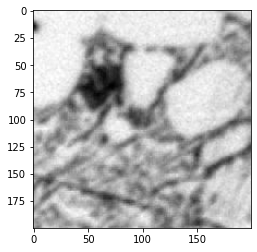

In [22]:
# Convert to float32
image = X_train[1].squeeze().astype(np.float32)

# Plot the image
plt.imshow(image, cmap='gray')
plt.show()

In [23]:
Y_train[1]

0.65

### Check histogramm for image values

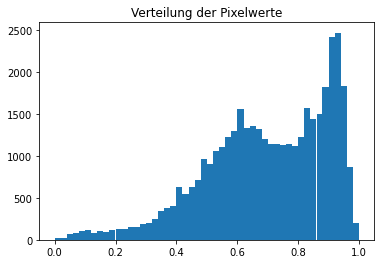

In [24]:
plt.hist(X_train[1].flatten(), bins=50, range=(0, 1))
plt.title('Verteilung der Pixelwerte')
plt.show()

In [25]:
print(f"Min: {np.min(X_train)}, Max: {np.max(X_train)}")

Min: 0.0, Max: 1.0


### Check if null or inf values in train_y

In [26]:
assert not np.any(np.isnan(image)), "NaN-values found"
assert not np.any(np.isinf(image)), "infinite values found"
assert X_train[5].shape == (200, 200, 1), "image has unexpected form"

### Check Data Distribution

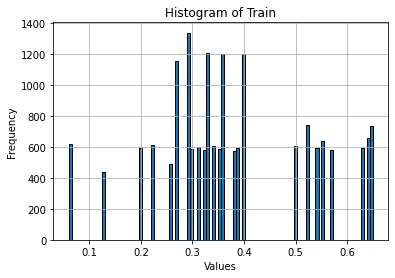

In [27]:
# Plot histogram
plt.hist(Y_train, bins=100, edgecolor='black')  # 100 bins, black edges
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Train")
plt.grid(True)

# Show the plot
plt.show()

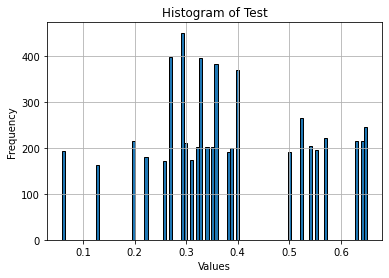

In [28]:
# Plot histogram
plt.hist(Y_test, bins=100, edgecolor='black')  # 100 bins, black edges
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Test")
plt.grid(True)

# Show the plot
plt.show()

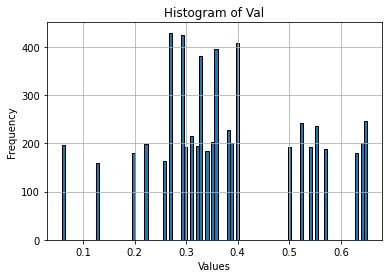

In [29]:
# Plot histogram
plt.hist(Y_val, bins=100, edgecolor='black')  # 100 bins, black edges
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Val")
plt.grid(True)

# Show the plot
plt.show()

## Training

In [30]:
logdir = r'..\logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'..\checkpoints\best_weights.weights.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

*It was trained with the Keras library on an Intel® Core™ I7-4970 CPU running at 3.60 GHz using 8 parallel processing units. Training was completed in 5 h—for 30 epochs total. A batch size of 32 was used for the training.* 

I will instead use my GPU, since its simply way faster.

In [33]:
# Activating GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
# If a GPU is available, enable memory growth (prevents memory issues)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


*Verify loss @ init. Verify that your loss starts at the correct loss value*

In [35]:
# Calculate the initial loss before training
init_loss = model.evaluate(X_val, Y_val, verbose=1)
print(f"Initial Loss: {init_loss[0]}")  # Should be approximately 1/3

6040/6040 [==============================] - 7s 1ms/sample - loss: 0.0531 - RootMeanSquaredError: 0.2304
Initial Loss: 0.05310068253847147


In [36]:
batch_size = 32   # the original paper used a batch size of 32
epochs = 1      # the original paper used 30 epochs
shuffle = True

# Training 
hist = model.fit(
    X_train, Y_train,
    epochs = epochs,
    validation_data = (X_val, Y_val), 
    batch_size = batch_size,
    shuffle = shuffle,
    verbose = 1,
    callbacks = [tensorboard_callback, model_checkpoint]
)

ERROR! Session/line number was not unique in database. History logging moved to new session 317
Train on 18117 samples, validate on 6040 samples
18117/18117 [==============================] - 39s 2ms/sample - loss: 0.0803 - RootMeanSquaredError: 0.2834 - val_loss: 1.2160 - val_RootMeanSquaredError: 1.1027


## Plot Train, Test and Val Loss

*add significant digits to your eval. When plotting the test loss run the evaluation over the entire (large) test set. Do not just plot test losses over batches and then rely on smoothing them in Tensorboard. We are in pursuit of correctness and are very willing to give up time for staying sane.*

In [37]:
# Evaluation on the entire test set
test_loss = model.evaluate(X_test, Y_test, batch_size = 1, verbose=1)

6039/6039 [==============================] - 11s 2ms/sample - loss: 1.3138 - RootMeanSquaredError: 1.1462 - ETA: 8s - loss: 1.3370 - RootMeanSquaredE - ETA: 8s - loss: 1.3183 - RootMeanSquaredError: 1.14 - ETA: 7s - loss: 1.3193 - RootMeanSquare - ETA - ETA: 


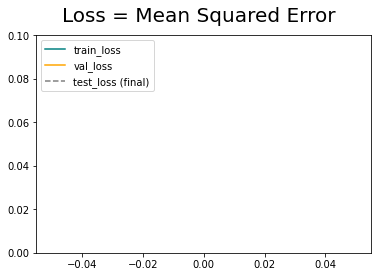

In [38]:
# Mean Squared Errors (Loss)
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.axhline(y=test_loss[0], color='gray', linestyle='--', label='test_loss (final)')
plt.ylim(0, 0.1)
fig.suptitle('Loss = Mean Squared Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [39]:
# # Root Mean Squared Errors (Metric) #wtf is going wrong here?
# fig = plt.figure()
# plt.plot(hist.history['root_mean_squared_error'], color='teal', label='train_rmse')
# plt.plot(hist.history['val_root_mean_squared_error'], color='orange', label='val_rmse')
# plt.axhline(y=test_loss[1], color='gray', linestyle='--', label='test_rmse (final)')
# plt.ylim(0, 1)
# fig.suptitle('Root Mean Squared Error', fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

## Evaluate Performance

The labels from the paper are in a range from 0.06 to 0.65.

### Performance

In [52]:
mse = MeanSquaredError()
rmse = RootMeanSquaredError()
mape = MeanAbsolutePercentageError()
mae = MeanAbsoluteError()

In [53]:
batch_size = 1  # If your model was trained with batches (for a more accurate test, it's still better to use 1)

y_true = []
y_pred = []

# Calculate metrics over all test data in batches
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i+batch_size]  # Take a batch of test data
    y_batch = Y_test[i:i+batch_size]  # Corresponding labels
    yhat_batch = model.predict(X_batch, verbose=0)  # Model prediction for the batch
    
    # Store true values and predictions
    y_true.append(y_batch)
    y_pred.append(yhat_batch)

    # Update metrics
    mse.update_state(y_batch, yhat_batch)
    rmse.update_state(y_batch, yhat_batch)
    mae.update_state(y_batch, yhat_batch)
    mape.update_state(y_batch, yhat_batch)
    
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# R²-Score
r2 = r2_score(y_true, y_pred)

In [54]:
print(f"Mean Squared Error (MSE): {mse.result().numpy():.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse.result().numpy():.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape.result().numpy():.2f}%")
print(f"Mean Absolute Error (MAPE): {mae.result().numpy():.2f}")
print(f"R²-Score: {r2}")

Mean Squared Error (MSE): 1.3137
Root Mean Squared Error (RMSE): 1.1462
Mean Absolute Percentage Error (MAPE): 318.52%
Mean Absolute Error (MAPE): 1.01
R²-Score: -60.262855105708546


## Predict SDAS for some specific test image

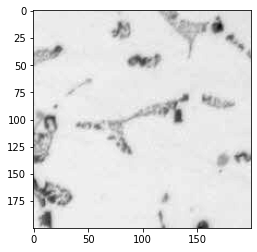

In [60]:
# Convert Image to float32 numpy array
image = X_test[0].squeeze().astype(np.float32)

# Plot the image
plt.imshow(image, cmap='gray')
plt.show()

In [61]:
print(np.expand_dims(X_test[0], axis=0).shape)

(1, 200, 200, 1)


In [62]:
yhat = model.predict(np.expand_dims(X_test[0], axis=0))

In [63]:
print("Ground Truth S_value: ", Y_test[0]*100)
print("Predicted S_value: ", round(yhat[0][0] * 100, 2))

Ground Truth S_value:  35.009765625
Predicted S_value:  -54.2


## Export Model

In [64]:
model.save(os.path.join(r'..\models', '11.4.25_v1.keras')) 

## Make Predictions on real images

In [65]:
test_dataset_version = "bmw_data" #210 images

test_dir = f'..\data\{test_dataset_version}' 

In [66]:
min_size = 200

results = []

# Conversion factor based on pixel size
pixel_per_µm = 1 / 0.728265817023213  # from Micha
F = 1.36 / pixel_per_µm

# for all images in test_dir
for img_name in os.listdir(test_dir):
    if img_name.endswith('.jpg') or img_name.endswith('.png'):

        print(img_name)
        
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape
        
        # Calculate the number of tiles
        rows = height // min_size
        cols = width // min_size
        
        # Split the image into tiles
        images = []
        for i in range(rows):
            for j in range(cols):
                y_start = i * min_size
                x_start = j * min_size
                y_end = min(y_start + min_size, height)
                x_end = min(x_start + min_size, width)
                image = img[y_start:y_end, x_start:x_end]
                images.append(image)
        
        # Collect model predictions
        predictions = []
        for image in images:
            resize = tf.image.resize(image[..., np.newaxis], (200, 200))
            predictions.append(model.predict(np.expand_dims(resize / 200, 0)))
        
        # Calculate the prediction
        S = np.median(predictions)
        SDAS_pred = S * 100 * F  # * 100, because we normalized the data when we imported it 
        
        # Extract the actual SDAS value from the filename
        try:
            SDAS_true = float(img_name.split('_')[1])
            results.append((SDAS_true, SDAS_pred))
        except:
            print(f"Warning: Couldn't extract SDAS-value from '{img_name}'!")

AC_20_B1.jpg
AC_20_B10.jpg
AC_20_B2.jpg
AC_20_B3.jpg
AC_20_B4.jpg
AC_20_B5.jpg
AC_20_B6.jpg
AC_20_B7.jpg
AC_20_B8.jpg
AC_20_B9.jpg
AC_22_B1.jpg
AC_22_B10.jpg
AC_22_B2.jpg
AC_22_B3.jpg
AC_22_B4.jpg
AC_22_B5.jpg
AC_22_B6.jpg
AC_22_B7.jpg
AC_22_B8.jpg
AC_22_B9.jpg
AC_27_B1.jpg
AC_27_B10.jpg
AC_27_B2.jpg
AC_27_B3.jpg
AC_27_B4.jpg
AC_27_B5.jpg
AC_27_B6.jpg
AC_27_B7.jpg
AC_27_B8.jpg
AC_27_B9.jpg
AC_29_B1.jpg
AC_29_B10.jpg
AC_29_B2.jpg
AC_29_B3.jpg
AC_29_B4.jpg
AC_29_B5.jpg
AC_29_B6.jpg
AC_29_B7.jpg
AC_29_B8.jpg
AC_29_B9.jpg
AC_31_B1.jpg
AC_31_B10.jpg
AC_31_B2.jpg
AC_31_B3.jpg
AC_31_B4.jpg
AC_31_B5.jpg
AC_31_B6.jpg
AC_31_B7.jpg
AC_31_B8.jpg
AC_31_B9.jpg
AC_33_B1.jpg
AC_33_B10.jpg
AC_33_B2.jpg
AC_33_B3.jpg
AC_33_B4.jpg
AC_33_B5.jpg
AC_33_B6.jpg
AC_33_B7.jpg
AC_33_B8.jpg
AC_33_B9.jpg
AC_35_B1.jpg
AC_35_B10.jpg
AC_35_B2.jpg
AC_35_B3.jpg
AC_35_B4.jpg
AC_35_B5.jpg
AC_35_B6.jpg
AC_35_B7.jpg
AC_35_B8.jpg
AC_35_B9.jpg
AC_38_B1.jpg
AC_38_B10.jpg
AC_38_B2.jpg
AC_38_B3.jpg
AC_38_B4.jpg
AC_38_B5.jpg
AC_3

In [67]:
# Separate true and predicted values
y_true = [true for true, pred in results]
y_pred = [pred for true, pred in results]

# Calculate the metrics
SDAS_mse = mean_squared_error(y_true, y_pred)
SDAS_rmse = np.sqrt(SDAS_mse)
SDAS_mae = mean_absolute_error(y_true, y_pred)
SDAS_r2 = r2_score(y_true, y_pred)

# MAPE (with protection against division by zero)
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)
SDAS_mape = np.mean(np.abs((y_true_array - y_pred_array) / y_true_array)) * 100

# Output the results
print(f"MSE: {SDAS_mse:.4f}")
print(f"RMSE: {SDAS_rmse:.4f}")
print(f"MAE: {SDAS_mae:.4f}")
print(f"MAPE: {SDAS_mape:.2f}%")
print(f"R²: {SDAS_r2:.4f}")

MSE: 18963.9176
RMSE: 137.7095
MAE: 132.6535
MAPE: 392.31%
R²: -160.4558


## ML-Flow 

Tutorial: https://www.youtube.com/watch?v=6ngxBkx05Fs&ab_channel=codebasics

What do we want to log for every run:
- model (with summary)
- hyperparameter
- dataset version
- metrics
- notebook

Run "mlflow ui" in your CMD first!

In [ ]:
mlflow.set_experiment("SDAS_Prediciton")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

with mlflow.start_run(run_name = 'vTEST_CNN'): # change with every run 
    
    # Save hyperparameters
    
    mlflow.log_params({
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'shuffle': shuffle,
        'optimizer': optimizer,
        # Save Data
        'dataset_version': dataset_version,  
        'test_dataset_version': test_dataset_version,
        'pixel_per_µm': pixel_per_µm
    }) 
    
    # Save metrics
    
    mlflow.log_metrics({
        'S_norm_Mean Squared Error': mse.result().numpy(),
        'S_norm_Root Mean Squared Error': rmse.result().numpy(), 
        'S_norm_Mean Absolute Percentage Error': mape.result().numpy(),
        'S_norm_Mean Absolute Error': mae.result().numpy(),
        'S_norm_R2-Score': r2,
        'SDAS_Mean Squared Error': SDAS_mse,
        'SDAS_Root_Mean Squared Error': SDAS_rmse,
        'SDAS_Mean Absolute Percentage Error': SDAS_mape, 
        'SDAS_Mean Absolute Error': SDAS_mae,
        'SDAS_R2-Score': SDAS_r2
    }) 
    
    # Save model
    
    if isinstance(model, tf.keras.Model):
        mlflow.keras.log_model(keras_model=model, artifact_path="cnn_model")
    else:
        print("The model isn't from the type tf.keras.Model!") 
        
    # Save notebook
    
    mlflow.log_artifact("CNN_SDAS_Prediction_Pipeline.ipynb", artifact_path="notebooks") # Name of notebook has to be correct

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Kleinau\AppData\Local\anaconda3\envs\cnn_test_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-6f454a24043c>", line 4, in <module>
    with mlflow.start_run(run_name = 'vTEST_CNN'): # change with every run
  File "C:\Users\Kleinau\AppData\Roaming\Python\Python36\site-packages\mlflow\tracking\fluent.py", line 290, in start_run
    active_run_obj = client.create_run(experiment_id=exp_id_for_run, tags=resolved_tags)
  File "C:\Users\Kleinau\AppData\Roaming\Python\Python36\site-packages\mlflow\tracking\client.py", line 265, in create_run
    return self._tracking_client.create_run(experiment_id, start_time, tags)
  File "C:\Users\Kleinau\AppData\Roaming\Python\Python36\site-packages\mlflow\tracking\_tracking_service\client.py", line 108, in create_run
    tags=[RunTag(key, value) for (key, value) in tags.items()],
  File "C:\User

## Load model from ML-Flow

In [69]:
# Enter RunID and Path
run_id = input("Enter your RunID: ")  # Ersetze mit deiner RunID
model_path = "cnn_model"

# load model
loaded_model = mlflow.keras.load_model(f"runs:/{run_id}/{model_path}")

# print model architecture
loaded_model.summary()

Enter your RunID: 5f4dbed50b9d4cb794422121409b3939
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      832       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2

In [70]:
y_pred = loaded_model.predict(X_test)
y_pred[:4]

array([[0.48237622],
       [0.39931035],
       [0.3769162 ],
       [0.4042401 ]], dtype=float32)

In [73]:
# optional

client = MlflowClient()

# load hyperparameter and metrcis
run_data = client.get_run(run_id).data
print("Hyperparameter:", run_data.params)
print("Metriken:", run_data.metrics)

# download current notebook
client.download_artifacts(run_id, f"notebooks_from_mlflow/{run_id}.ipynb", "./")

ERROR! Session/line number was not unique in database. History logging moved to new session 295
Hyperparameter: {'batch_size': '1', 'dataset_version': 'merged_unaugmented_7.4.25_v1', 'epochs': '500', 'learning_rate': '0.0001', 'optimizer': '<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001607C7CFEF0>', 'pixel_per_µm': '1.3731250000000008', 'shuffle': 'True', 'test_dataset_version': 'bmw_data'}
Metriken: {'SDAS_Mean Absolute Error': 8.259512438374038, 'SDAS_Mean Absolute Percentage Error': 21.414485668030924, 'SDAS_Mean Squared Error': 109.0461483581414, 'SDAS_R2-Score': 0.0715982967307548, 'SDAS_Root_Mean Squared Error': 10.442516380554133, 'S_norm_Mean Absolute Error': 0.06883599609136581, 'S_norm_Mean Absolute Percentage Error': 22.057796478271484, 'S_norm_Mean Squared Error': 0.007928644306957722, 'S_norm_R2-Score': 0.6302707104442064, 'S_norm_Root Mean Squared Error': 0.08904293179512024}
